# Functions

In [1]:
import networkx as nx
import math
import matplotlib.pyplot as plt
from networkx.algorithms import tree
import pandas as pd
import operator

In [2]:
from lineage import graphs, similarity


def compute_graph_metrics(nb_name):
    gt_df = pd.DataFrame(columns = ['nb_name', 'vertices', 'edges', 'diff_edge_tree'])
    g_truth = get_graph(nb_name)
    vertices = len(g_truth.nodes)
    edges = len(g_truth.edges)
    gt_df = gt_df.append({
            'nb_name': nb_name,
            'vertices': vertices,
            'edges': edges,
            'diff_edge_tree': (vertices - 1) - edges
        }, ignore_index=True)
    return gt_df
    

def display_notebook(nb_name):
    g_truth = get_graph(nb_name)
    graphs.draw_graph(g_truth, canvas_size=(30,30))
    return g_truth
    

In [51]:
nb_list = [
    'nb_331056',
    'nb_23457',
    # 'nb_336256', #
    'nb_33614',
    # 'nb_650868', #
    'nb_316514',
    'nb_386796',
    'nb_266913',
    'nb_417011',
    'nb_269991',
    'nb_495072',
    'nb_315236',
    'nb_484354',
    'nb_772851',
    'nb_924102',
    'nb_921915',
    'nb_986282',
    # 'nb_582525', #
    'nb_639263',
]

# Post Mortem

In [52]:
base_dir = '/media/suhail/Data/experiments/reexec/res/'


In [3]:

def get_graph(nb_name):
    result_file = base_dir+nb_name+'/'+nb_name+'_gt.pkl'
    return nx.read_gpickle(result_file)

def get_graph_edge_list(nb_name, metric):
    result_file = base_dir+nb_name+'/inferred/infered_mst_'+metric+'.csv'
    #return nx.read_edgelist(result_file, delimiter=',', data=(('weight', float),))
    return nx.read_edgelist(result_file)

def get_distance_matrix(nb_name, metric):
    result_file = base_dir+nb_name+'/inferred/'+metric+'_sim.csv'
    return pd.read_csv(result_file, index_col=0)


In [4]:
def generate_explaination_graph(g_truth, g_inferred, distance_matrix):
    exp_graph = g_truth.copy()
    nx.set_edge_attributes(exp_graph, True, 'truth')
    for edge_t in g_inferred.edges(data=True):
        exp_graph.add_edge(edge_t[0], edge_t[1], inferred=True)
        if g_truth.has_edge(edge_t[0], edge_t[1]):
            exp_graph[edge_t[0]][edge_t[1]]['correct']=True
        elif g_truth.has_edge(edge_t[1], edge_t[0]):
            exp_graph[edge_t[0]][edge_t[1]]['correct']=True
        else:
            exp_graph[edge_t[0]][edge_t[1]]['correct']=False
    
    for edge_t in exp_graph.edges():
        try:
            exp_graph[edge_t[0]][edge_t[1]]['weight'] = distance_matrix[edge_t[0]][edge_t[1]]
        except KeyError as e:
            exp_graph[edge_t[0]][edge_t[1]]['weight'] = 0.0
        
    return exp_graph
    

In [55]:
from networkx.drawing.nx_agraph import graphviz_layout

# Draw Graph Plot:
def draw_exp_graph(G, canvas_size=(20, 20), node_size=1500,
               layout_fn=graphviz_layout, **kwargs):
    # Set Canvas Size
    plt.figure(10, figsize=canvas_size)

    # Remove axes and set a margin to prevent cut-off
    ax = plt.gca()
    [sp.set_visible(False) for sp in ax.spines.values()]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0.30)

    root = kwargs.pop('root', None)
    print(root)
    if root is None:
        print(G)
        root = sorted(nx.degree(G), key=lambda kv: kv[1])[0][0]
        print(root)
    
    pos = layout_fn(G, root=root, prog='dot')

    try:
        edge_labels = {i[0:2]: '{0:.4f}'.format(i[2]['weight'])
                       for i in G.edges(data=True)}
    except:
        edge_labels = None

    nx.draw_networkx_nodes(G, pos,
                       node_color='r',
                       node_size=500,
                       alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    
    correct_edges = [edge for edge in G.edges(data=True) 
                     if 'correct' in edge[2] and edge[2]['correct']]
    
    print(correct_edges)
    
    nx.draw_networkx_edges(G, pos,
                       edgelist=correct_edges,
                       width=8, alpha=0.5, edge_color='green', arrows=False)
    
    incorrect_edges = [edge for edge in G.edges(data=True) 
                       if 'correct' in edge[2] and edge[2]['correct'] == False]
    
    nx.draw_networkx_edges(G, pos,
                       edgelist=incorrect_edges,
                       width=3, alpha=0.5, edge_color='red', style='dashed', arrows=False)
    
    # print(incorrect_edges)
    
    gt_edges = [edge for edge in G.edges(data=True) 
                       if 'truth' in edge[2] and edge[2]['truth'] == True]
    
    nx.draw_networkx_edges(G, pos,
                       edgelist=gt_edges,
                       width=2, alpha=0.75, edge_color='black', arrows=True)
    already_marked = {}
    edge_labels = {}
    for i in G.edges(data=True):
        edge_label = ''
        if 'truth' in i[2] and i[2]['truth'] == True:
            if i[2]['operation'] is not None:
                edge_label = edge_label + i[2]['operation']
                already_marked[(i[0],i[1])] = True
        
        if 'weight' in i[2]:
            edge_label = edge_label + ' ('+'{0:.8f}'.format(i[2]['weight'])+')'
        
        if (i[1],i[0]) not in already_marked.keys():
            edge_labels[(i[0],i[1])] = edge_label
                  
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

    
    plt.show()

In [56]:
def generate_and_draw_graph(nb_name, metric, root=None):
    g_truth = get_graph(nb_name)
    g_infered = get_graph_edge_list(nb_name,metric)
    dist = get_distance_matrix(nb_name,metric)
    exp_graph = generate_explaination_graph(g_truth, g_infered, dist)
    draw_exp_graph(exp_graph, canvas_size=(30,30))


nb_331056
None

crimesByMonth.csv
[('MetPoliceCrimeStats.csv', 'crimes.csv', {'operation': 'load', 'truth': True, 'inferred': True, 'correct': True, 'weight': 1.0}), ('typeLoc.csv', 'typeLoc__1.csv', {'operation': 'merge', 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.8333333333333334}), ('typeLoc__1.csv', 'locationRecode.csv', {'inferred': True, 'correct': True, 'weight': 0.016988062442607896}), ('typeLoc__2.csv', 'typeLoc__3.csv', {'operation': 'groupby', 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.03112947658402204})]


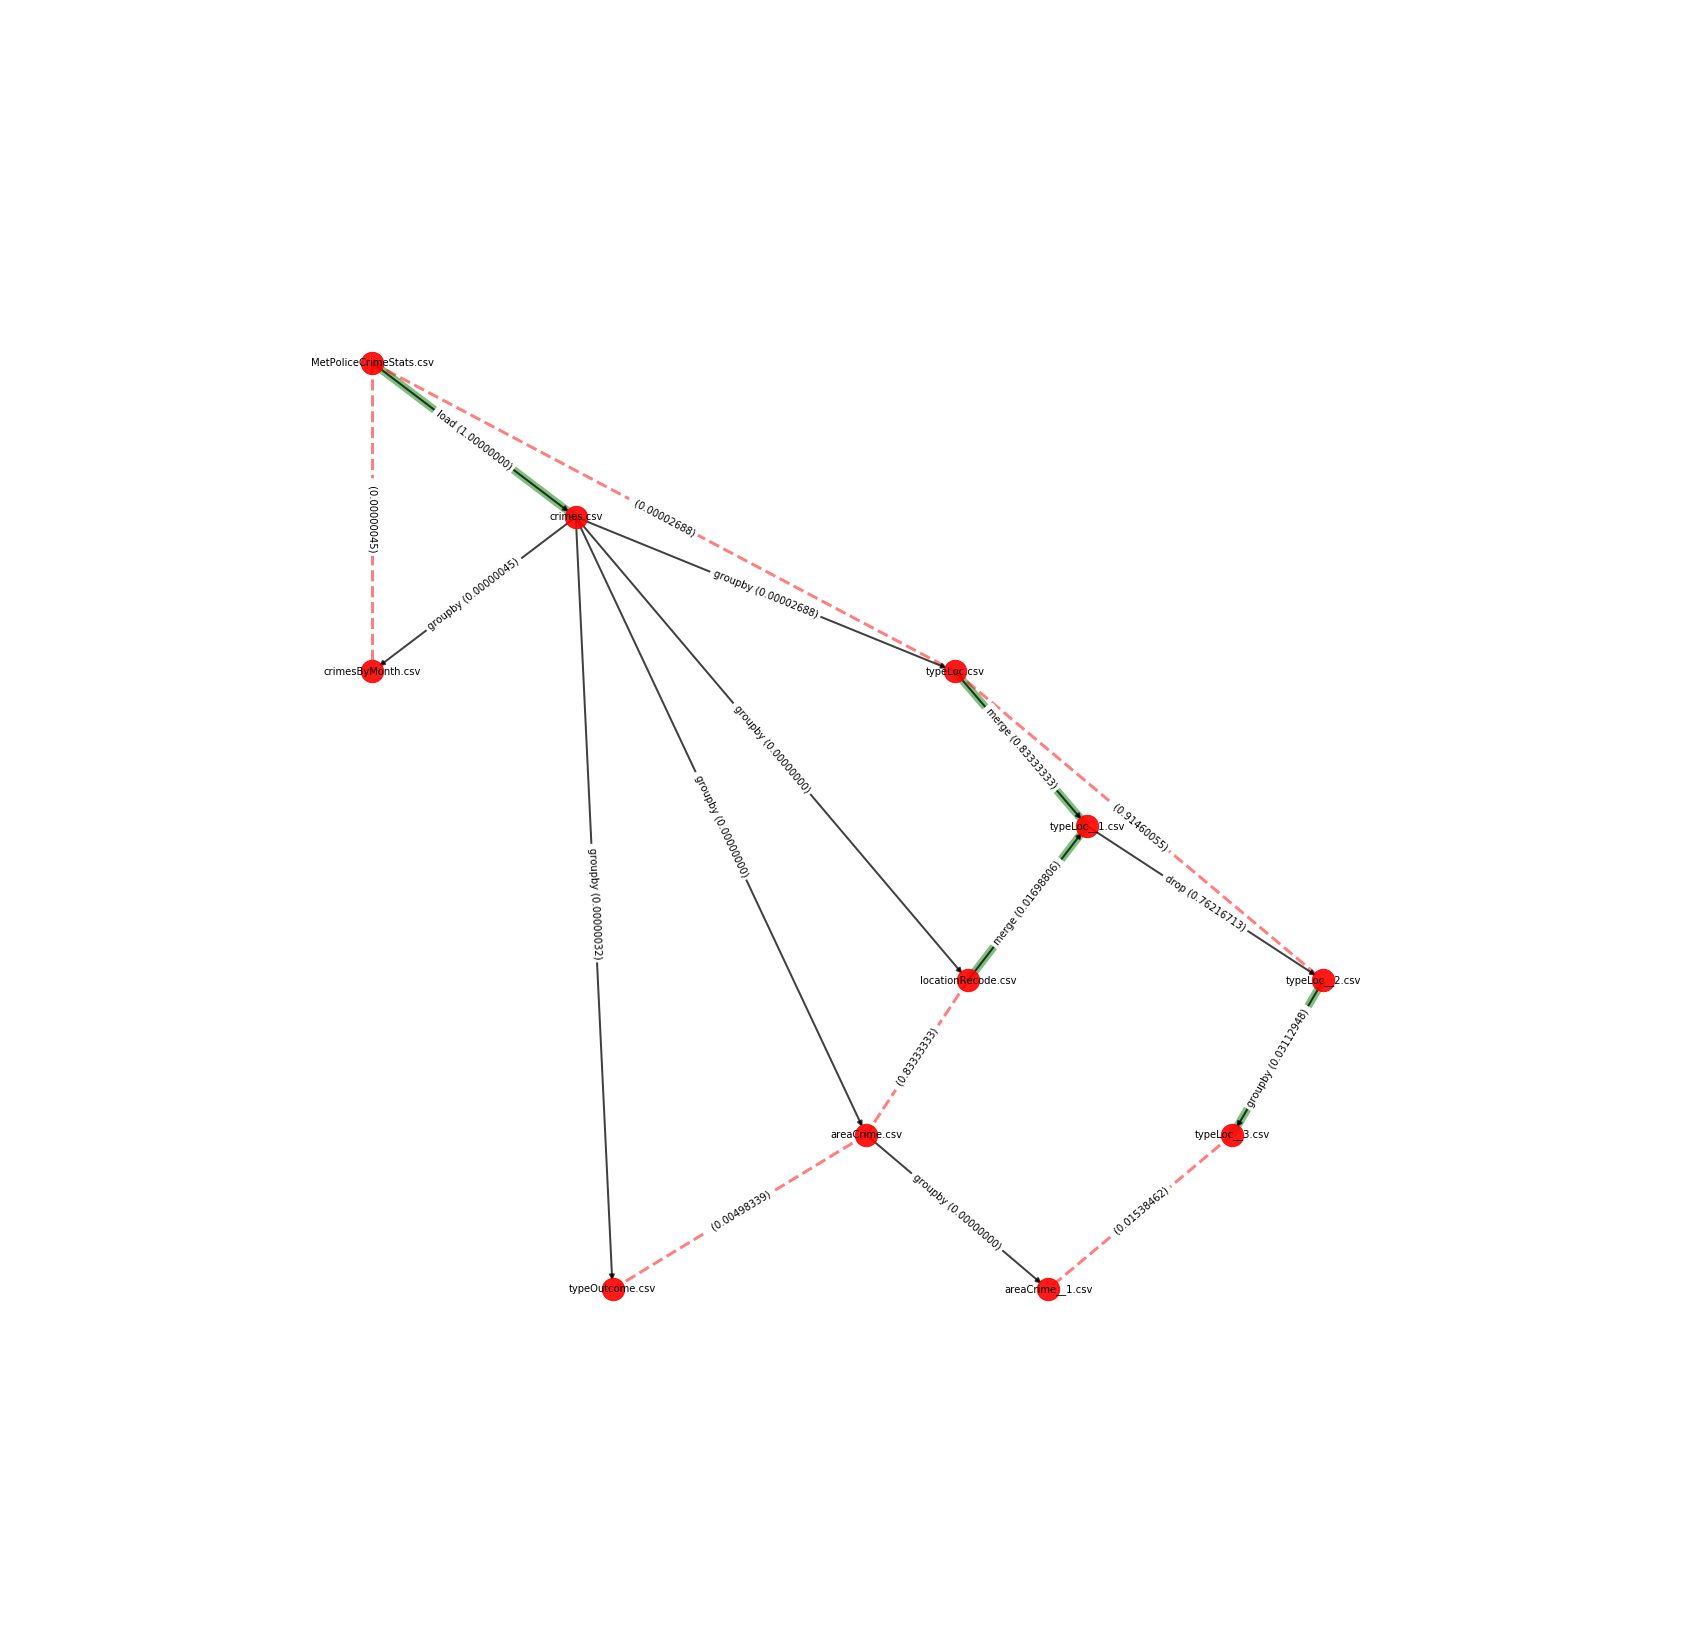

nb_23457
None

StarWars.csv
[('star_wars.csv', 'star_wars__1.csv', {'operation': 'notnull', 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.8879971622400568}), ('star_wars__1.csv', 'star_wars__2.csv', {'operation': 'rename', 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.6885252184577648}), ('star_wars__2.csv', 'star_wars__3.csv', {'operation': 'rename', 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.7272727272727273}), ('star_wars__3.csv', 'not_fan.csv', {'operation': None, 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.23946037099494094})]


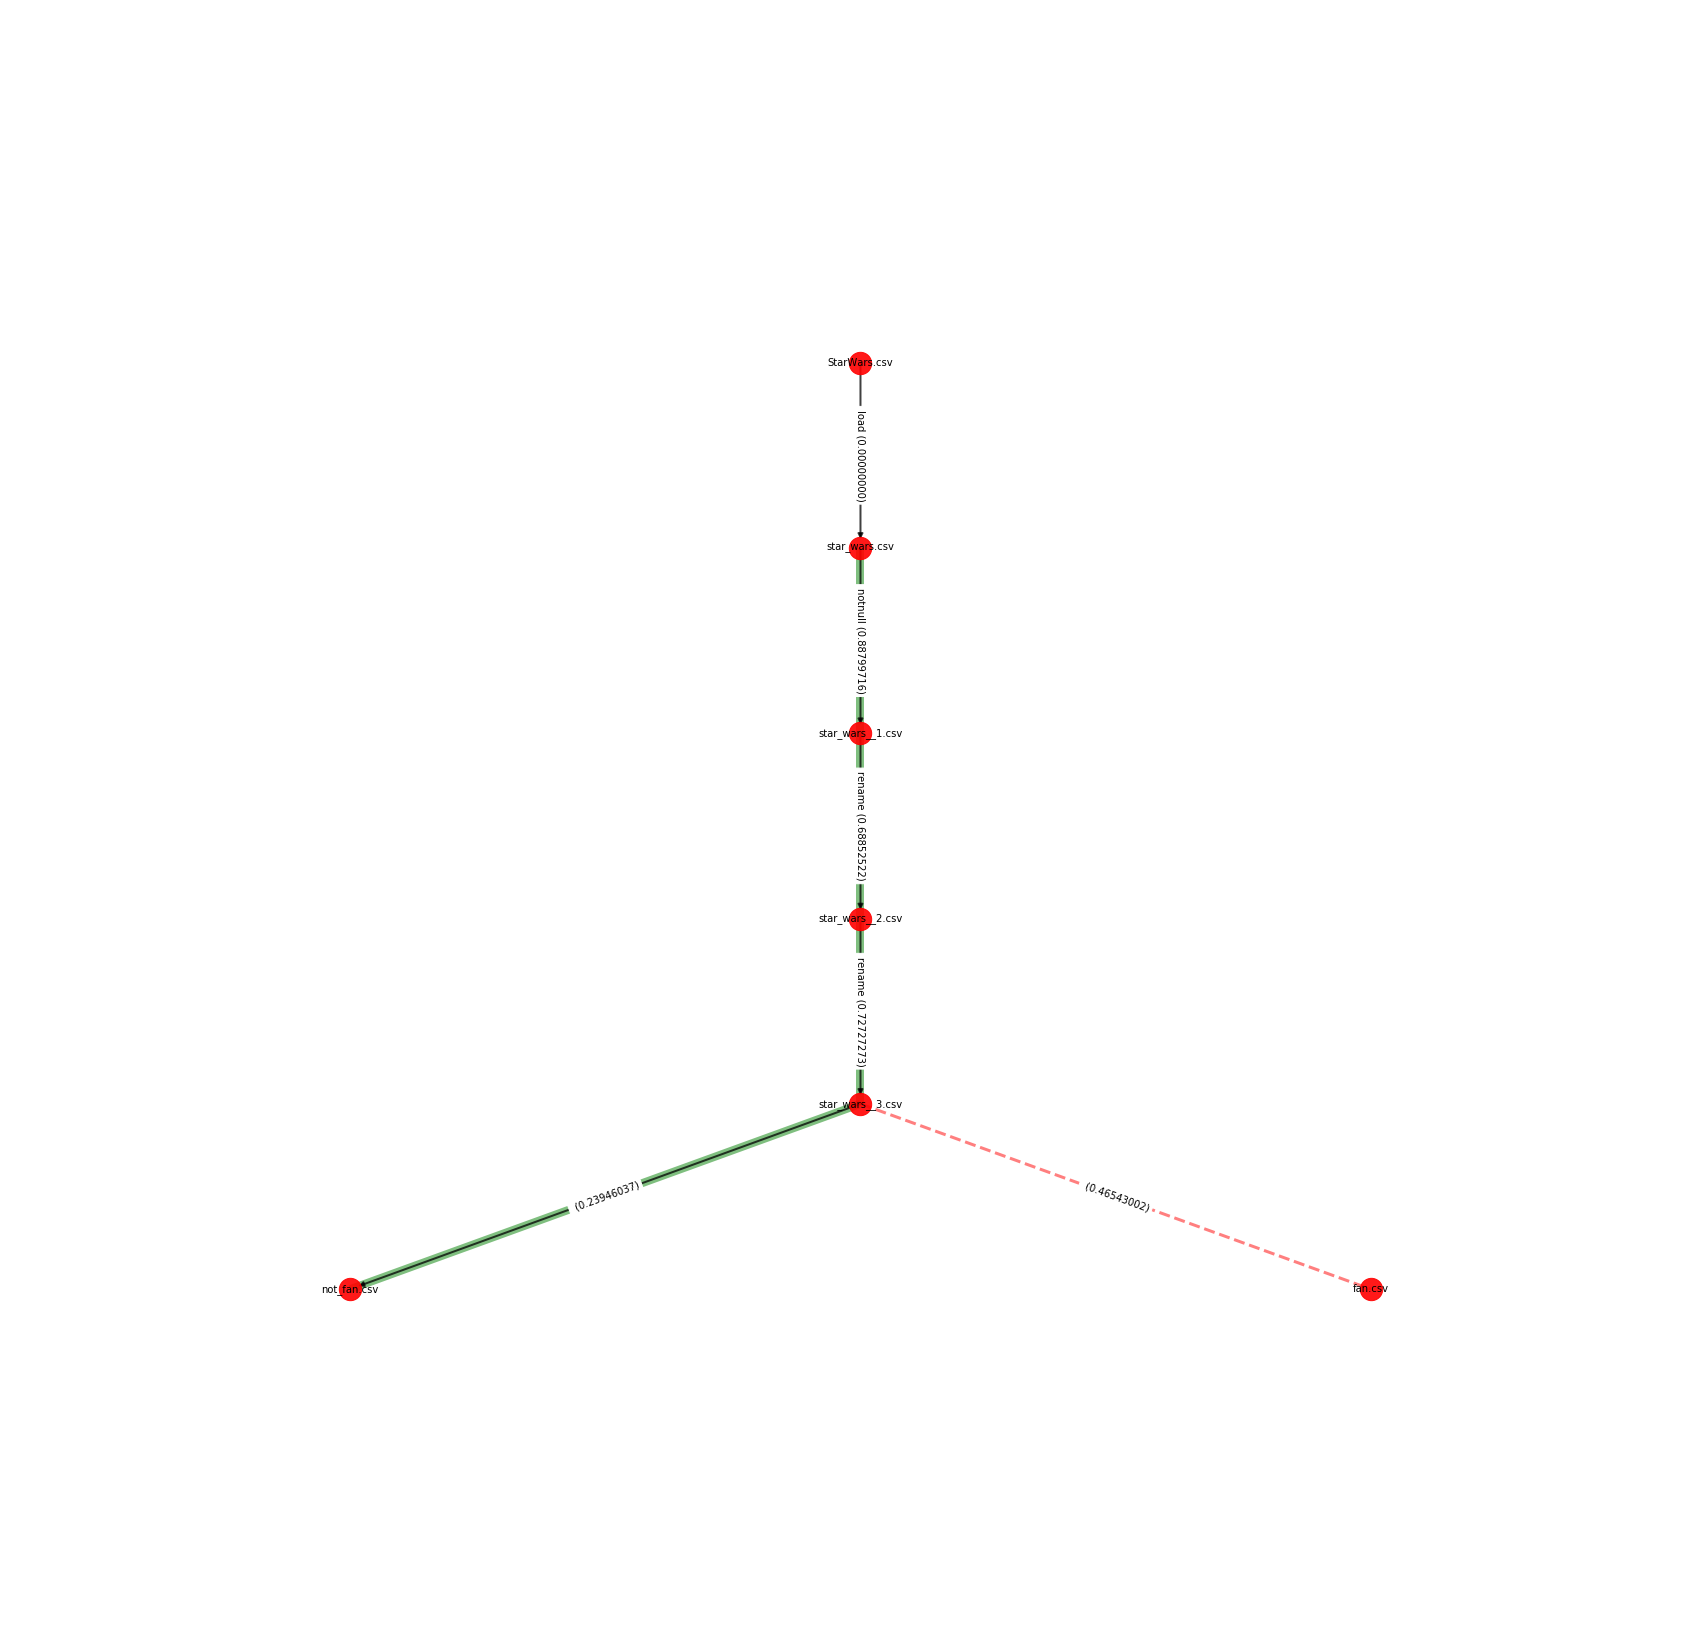

nb_33614
None

messy1.csv
[('tidy__1.csv', 'messy.csv', {'inferred': True, 'correct': True, 'weight': 0.16666666666666666}), ('tidy__2.csv', 'messy__1.csv', {'inferred': True, 'correct': True, 'weight': 0.05555555555555555}), ('tidy__3.csv', 'messy__2.csv', {'inferred': True, 'correct': True, 'weight': 0.018518518518518517}), ('molten.csv', 'tidy__4.csv', {'operation': 'copy', 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.46875}), ('molten.csv', 'messy__3.csv', {'inferred': True, 'correct': True, 'weight': 0.0017095310136157338}), ('molten__1.csv', 'messy__4.csv', {'inferred': True, 'correct': True, 'weight': 0.15714285714285714}), ('molten__2.csv', 'molten__1.csv', {'inferred': True, 'correct': True, 'weight': 0.42857142857142855}), ('molten__3.csv', 'tidy_track.csv', {'operation': 'groupby', 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.16666666666666666}), ('molten__3.csv', 'tidy_rank.csv', {'operation': 'merge', 'truth': True, 'inferred': True, 'corr

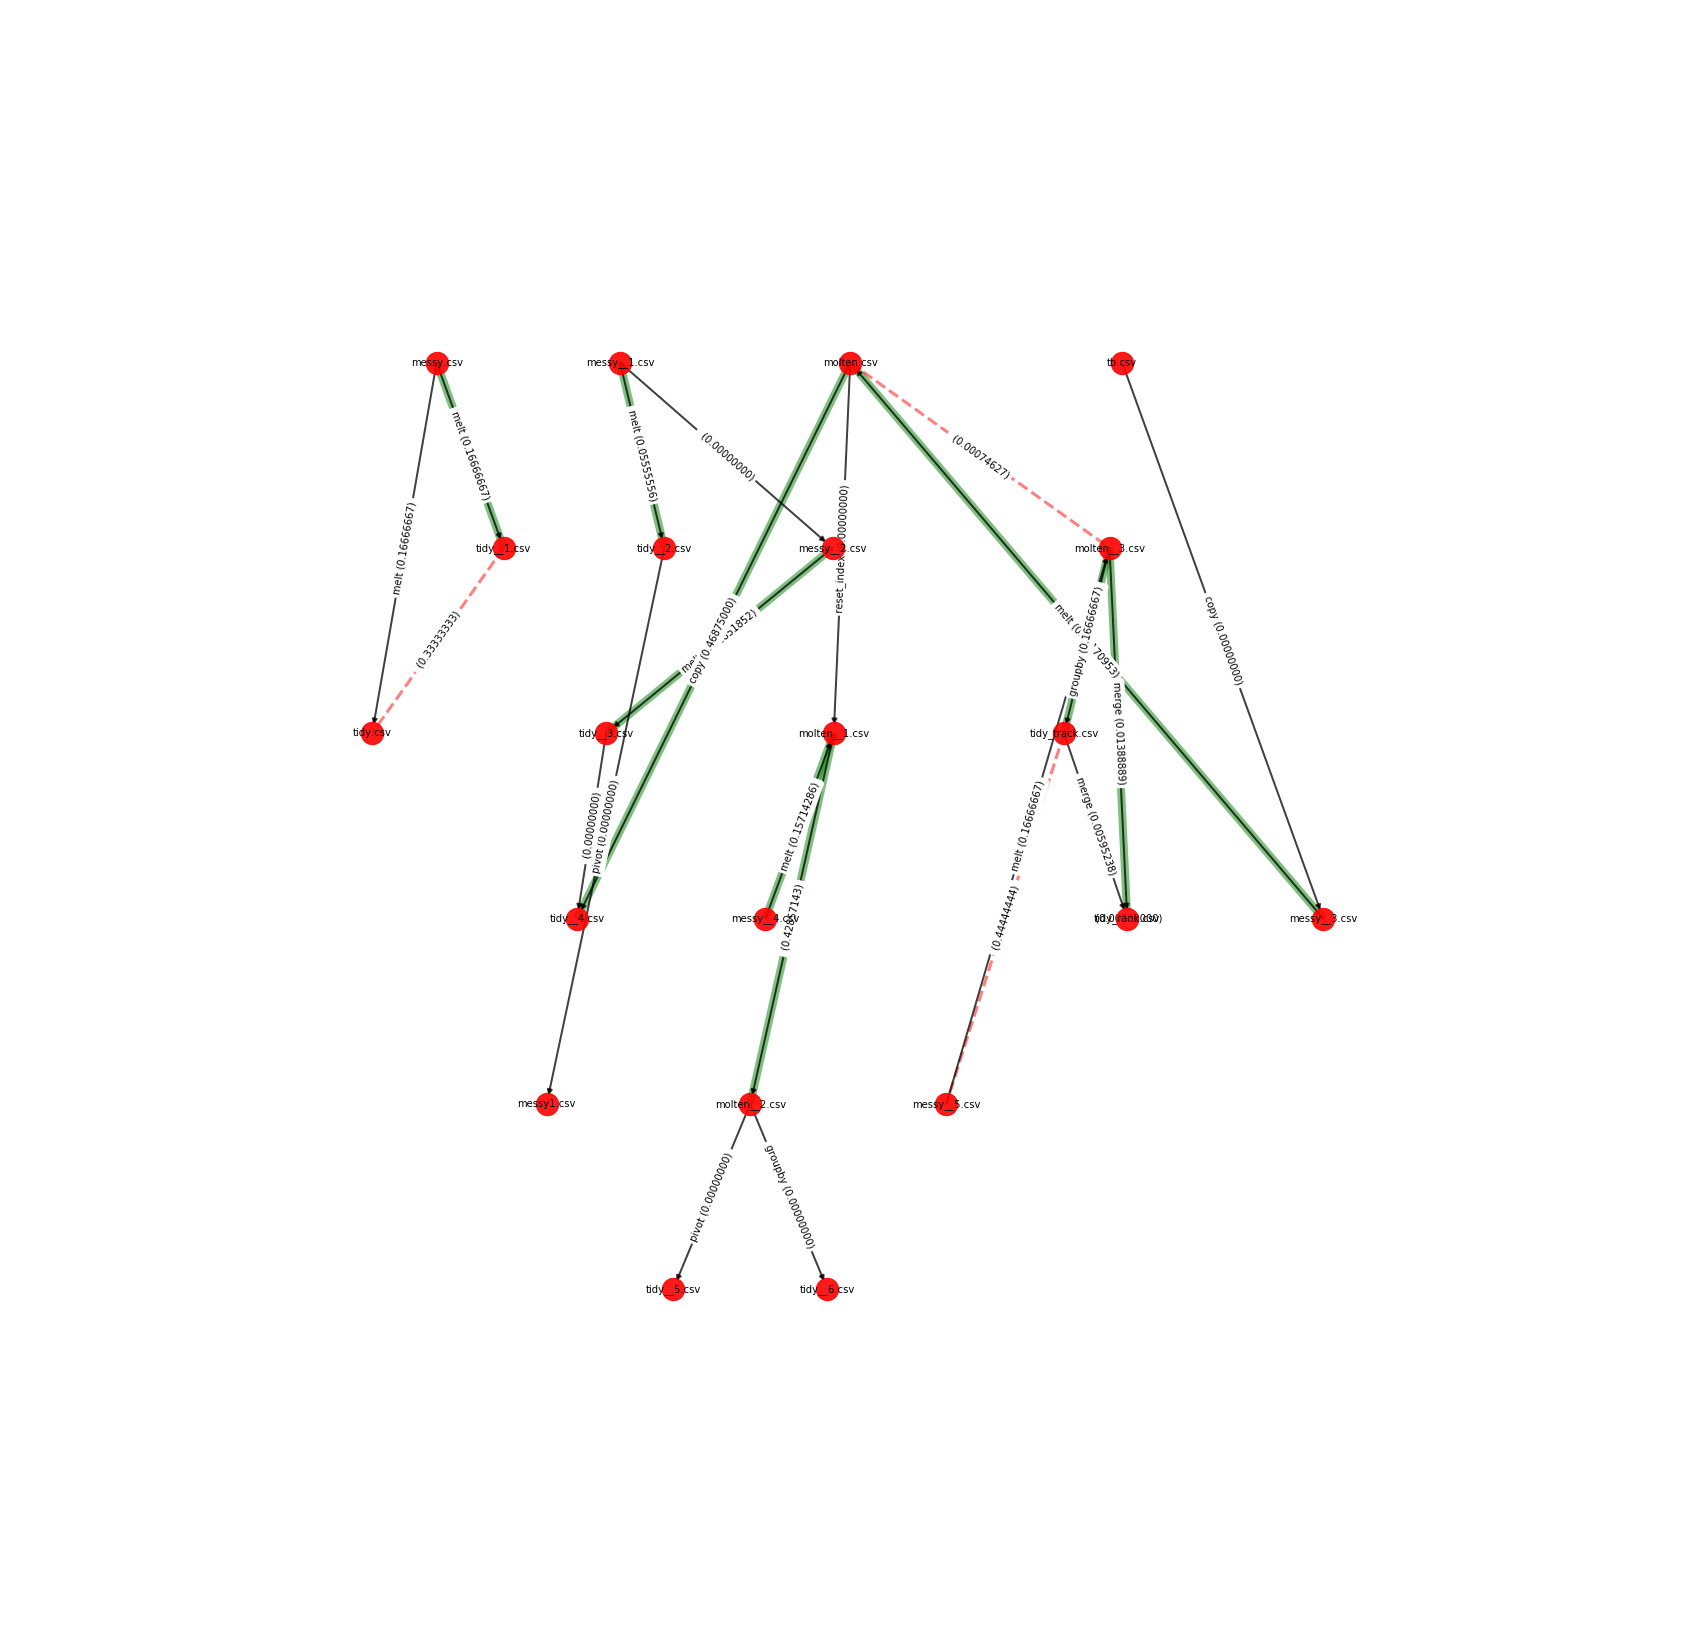

nb_316514
nb_386796
None

gp1.csv
[('gp2__2.csv', 'gp2__1.csv', {'inferred': True, 'correct': True, 'weight': 0.9})]


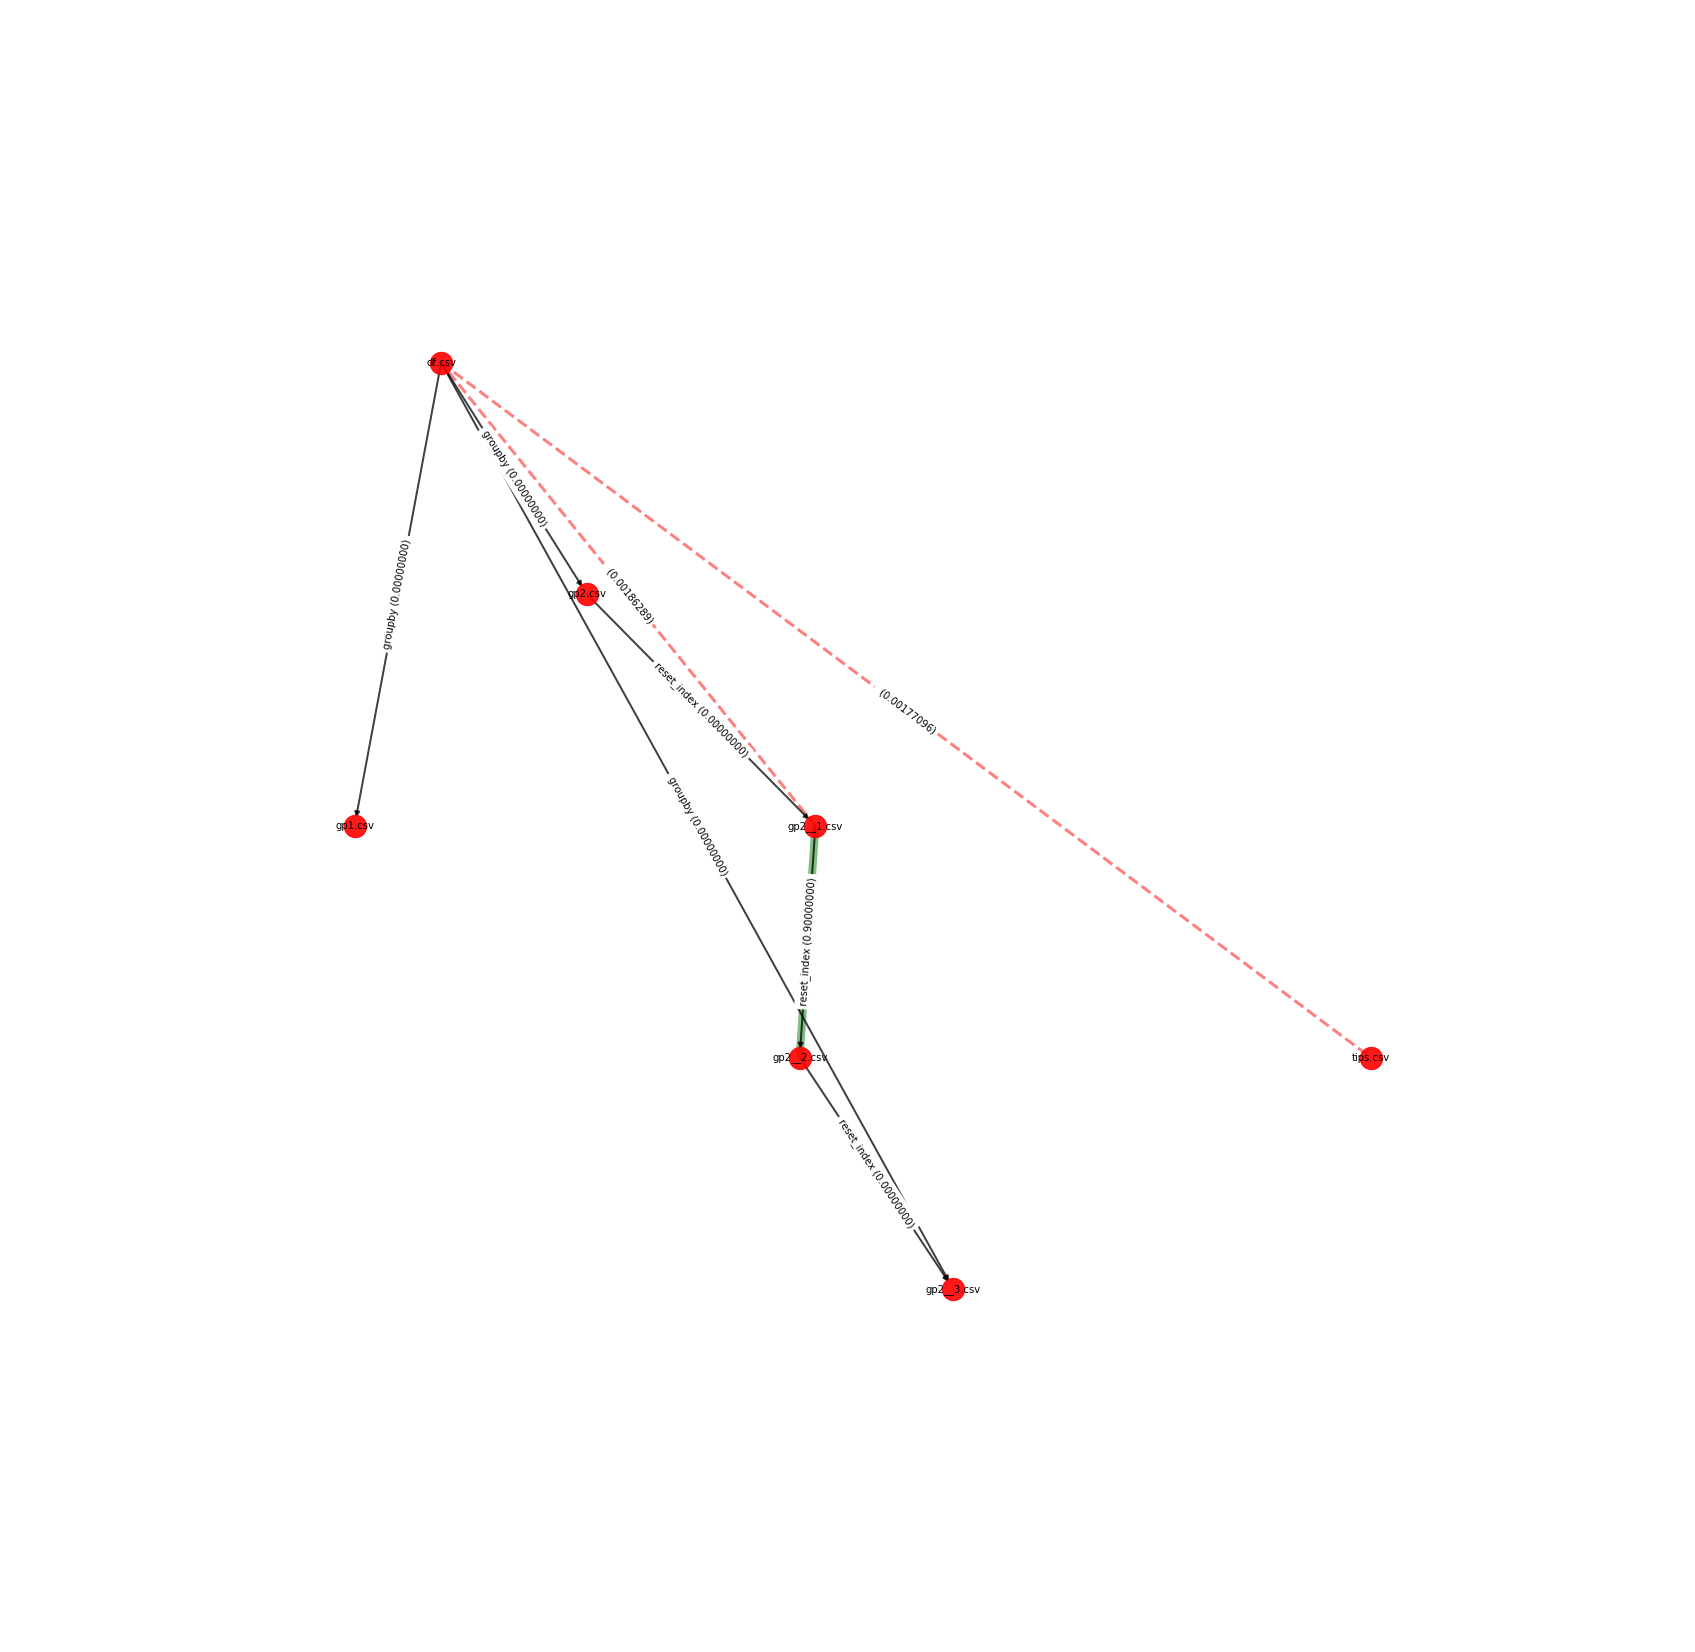

nb_266913
None

StarWars.csv
[('star_wars.csv', 'star_wars__1.csv', {'operation': 'dropna', 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.8879971622400568}), ('star_wars__2.csv', 'star_wars__1.csv', {'inferred': True, 'correct': True, 'weight': 0.6885252184577648}), ('star_wars__3.csv', 'females.csv', {'operation': None, 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.4629005059021922}), ('star_wars__3.csv', 'star_wars__4.csv', {'operation': 'rename', 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.9487179487179488}), ('star_wars__3.csv', 'star_wars__2.csv', {'inferred': True, 'correct': True, 'weight': 0.7272727272727273})]


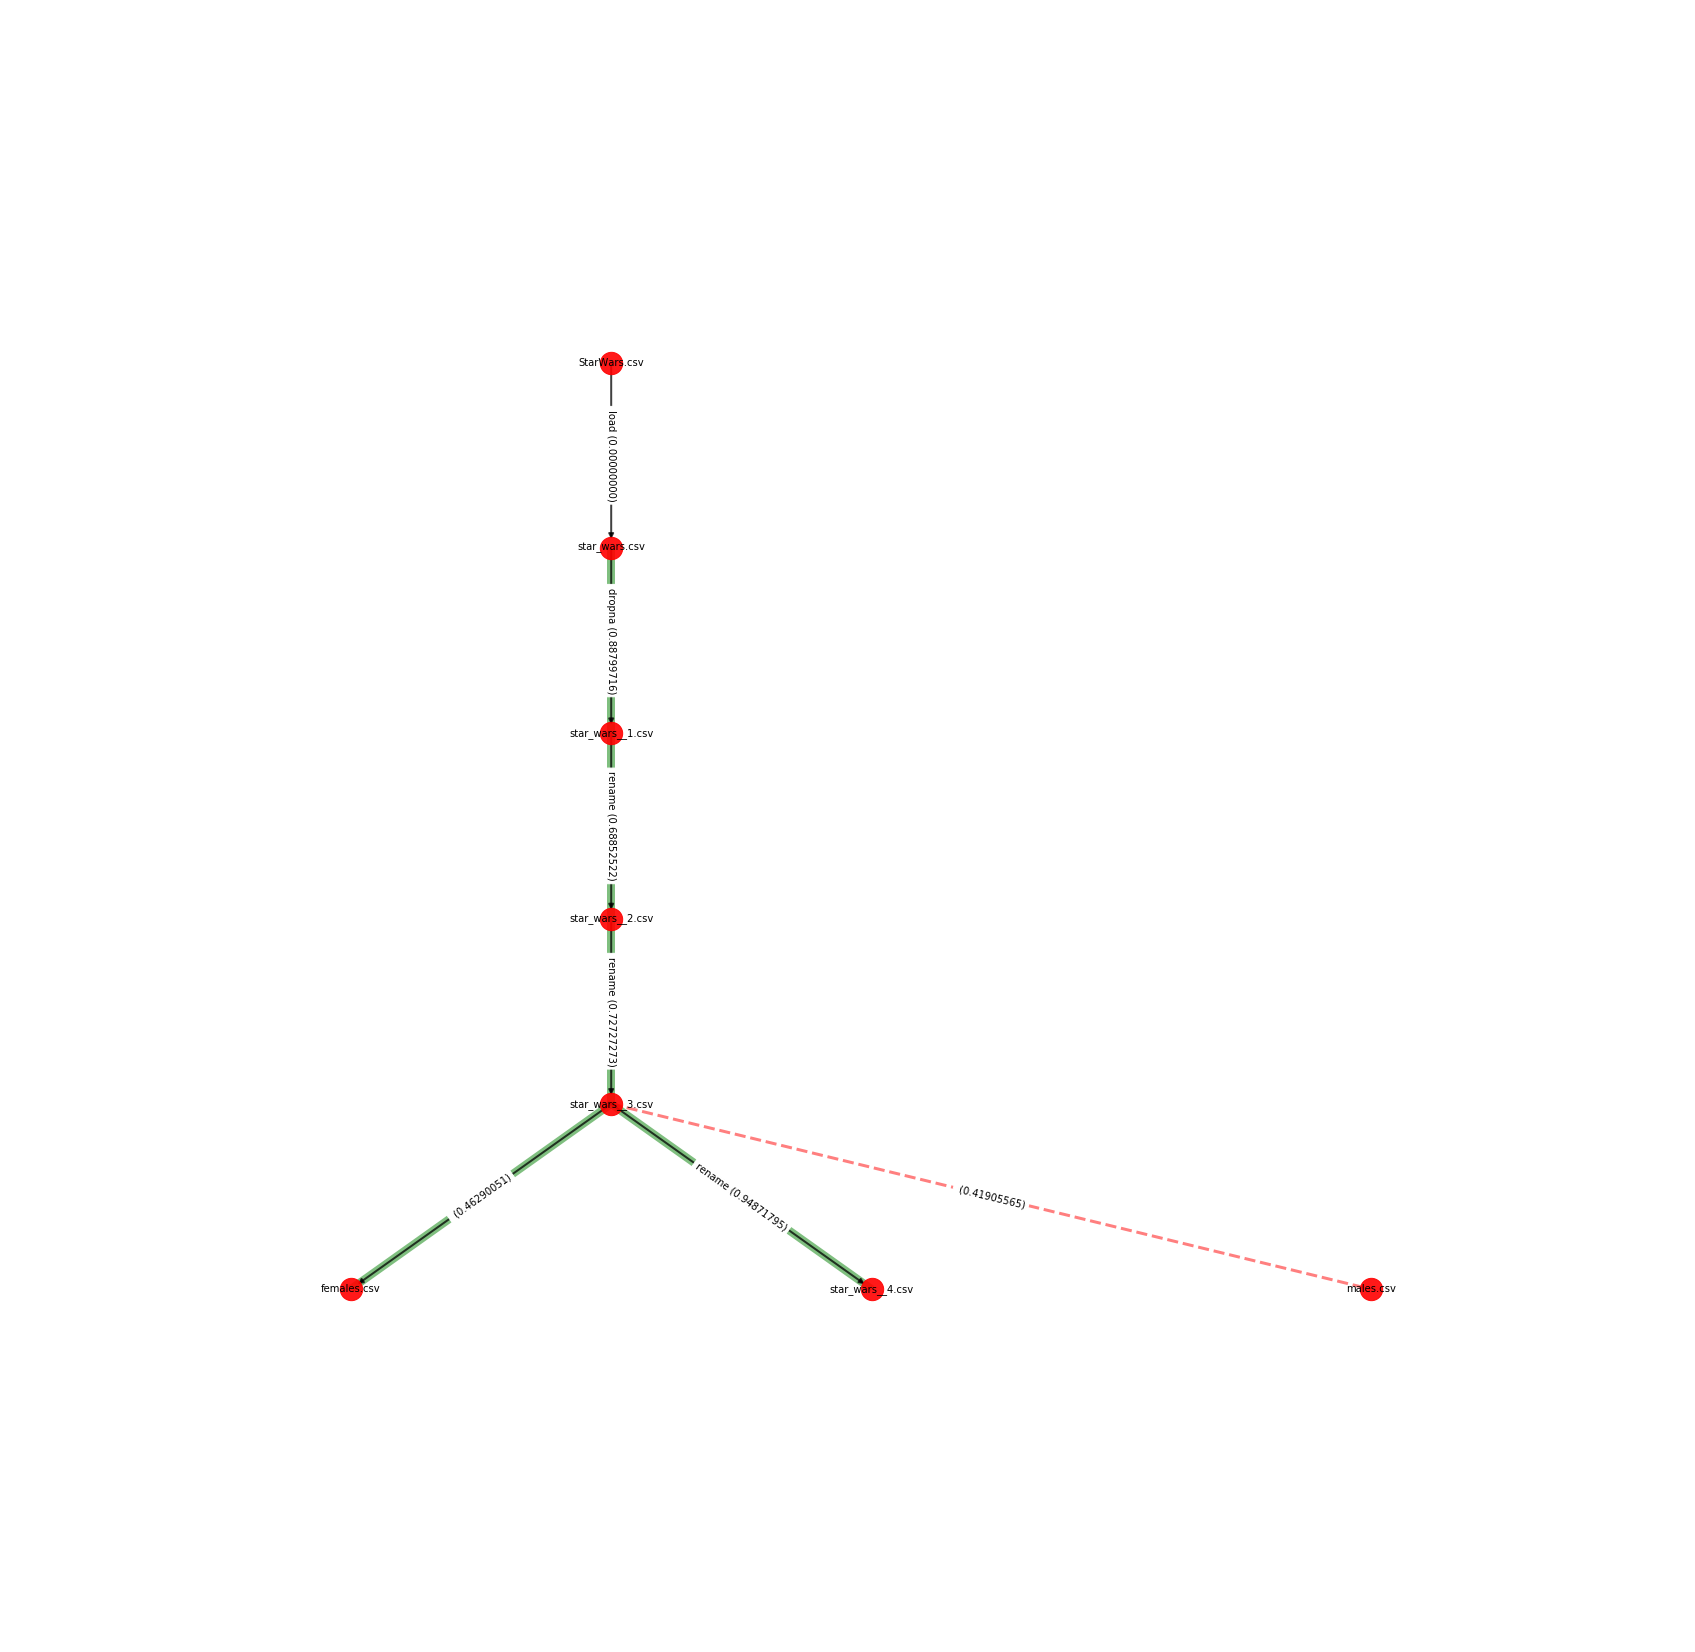

nb_417011
None

committees.csv
[('props.csv', 'prop.csv', {'operation': None, 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.0196078431372549}), ('merged.csv', 'support.csv', {'operation': None, 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.1826086956521739}), ('merged.csv', 'contribs.csv', {'inferred': True, 'correct': True, 'weight': 0.00022466994211792806}), ('oppose.csv', 'merged.csv', {'inferred': True, 'correct': True, 'weight': 0.8173913043478261})]


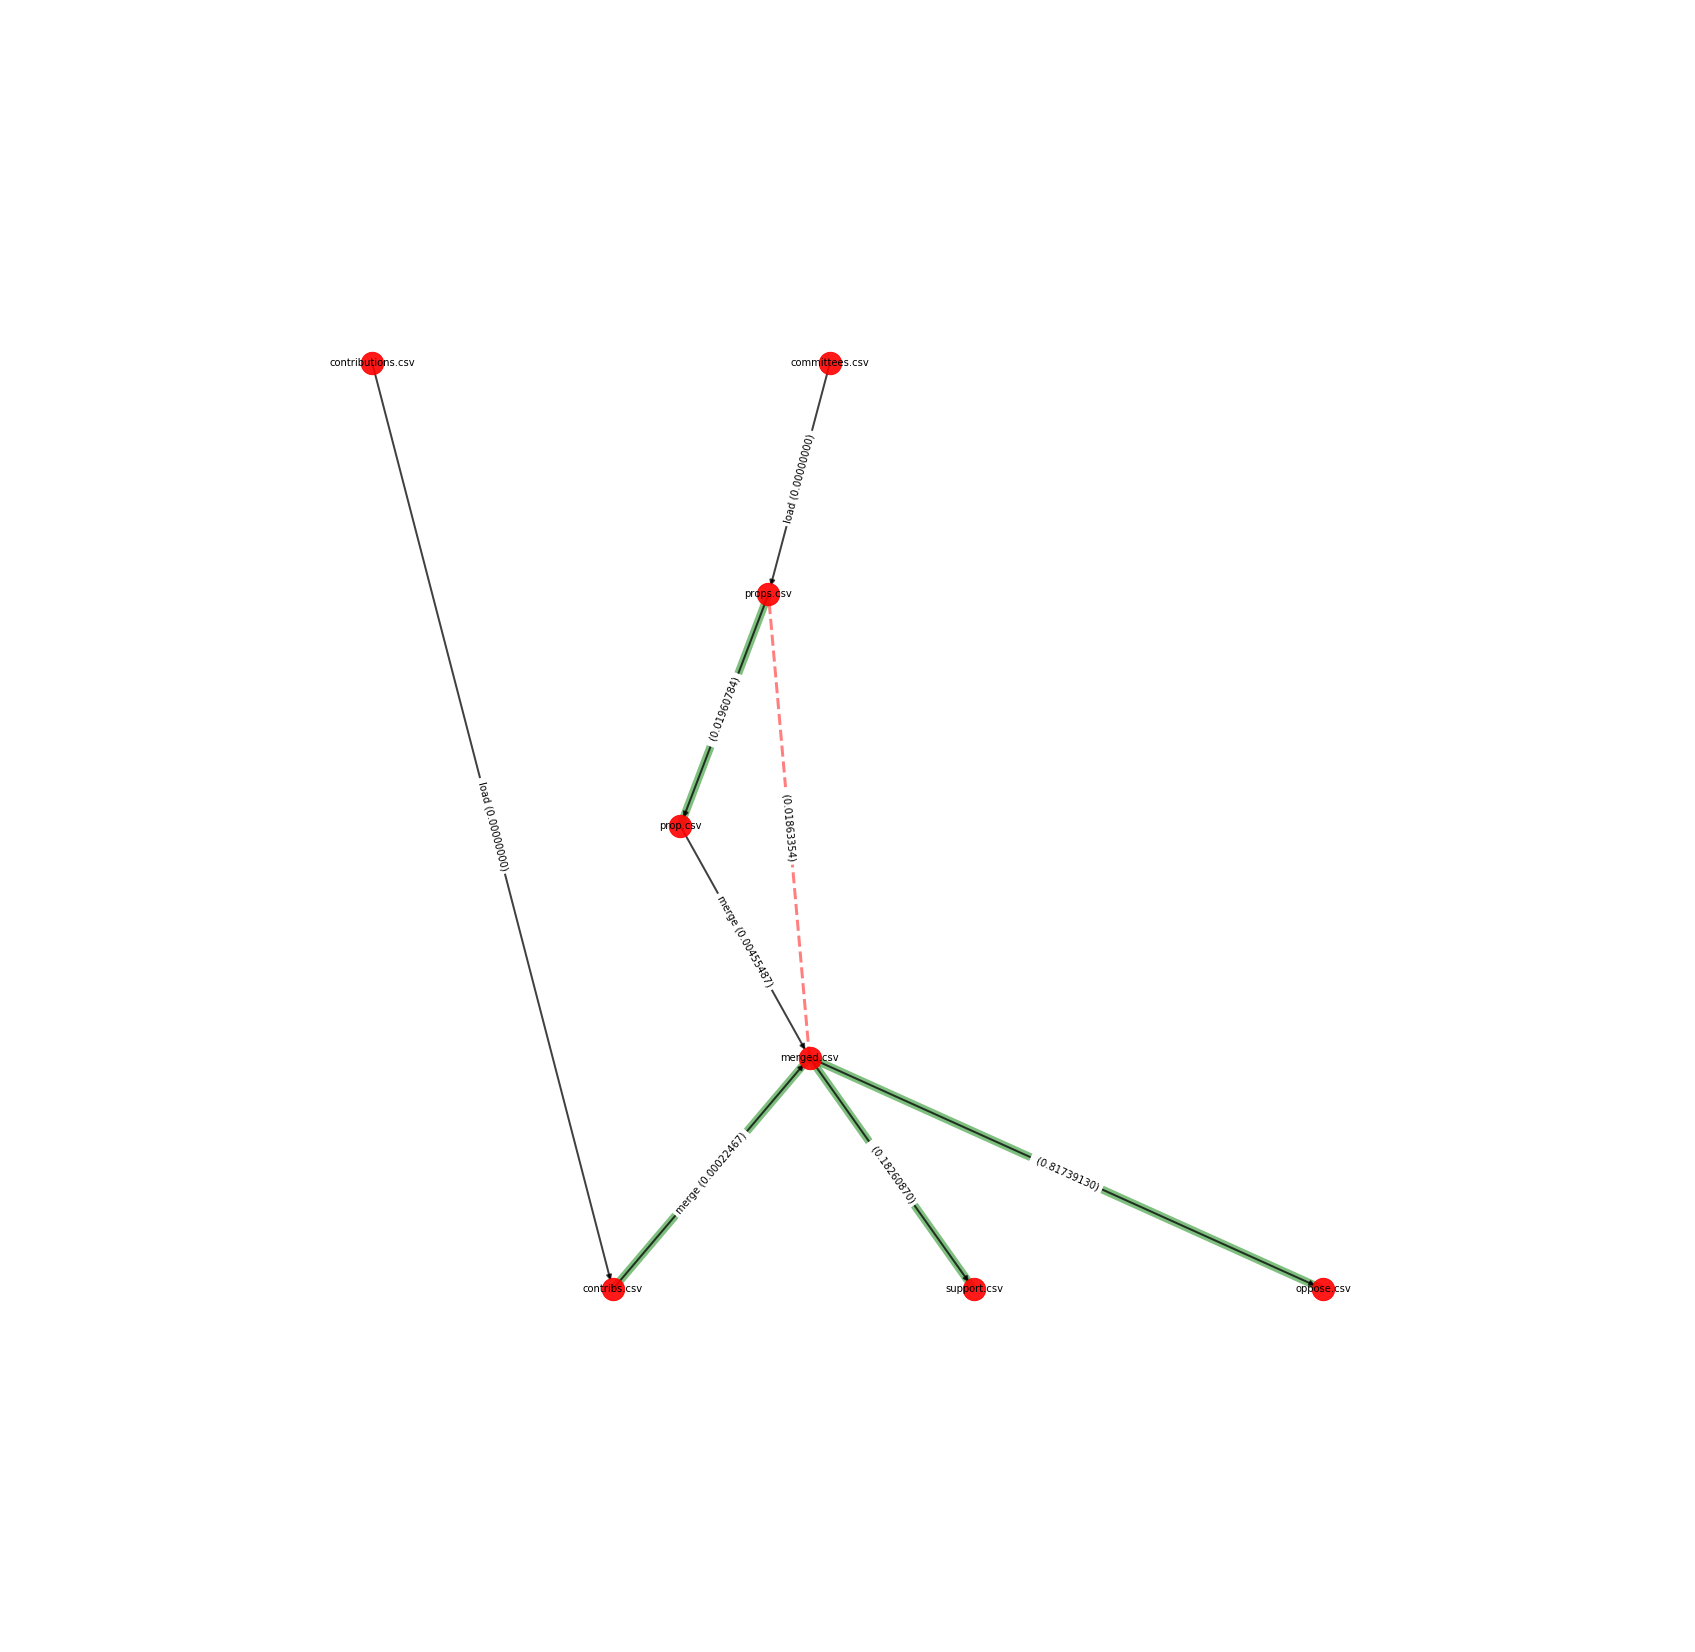

nb_269991
None

realtor_importio_raw.csv
[('df__1.csv', 'df.csv', {'inferred': True, 'correct': True, 'weight': 0.6817361487096192}), ('df__2.csv', 'df__1.csv', {'inferred': True, 'correct': True, 'weight': 0.973817151306062})]


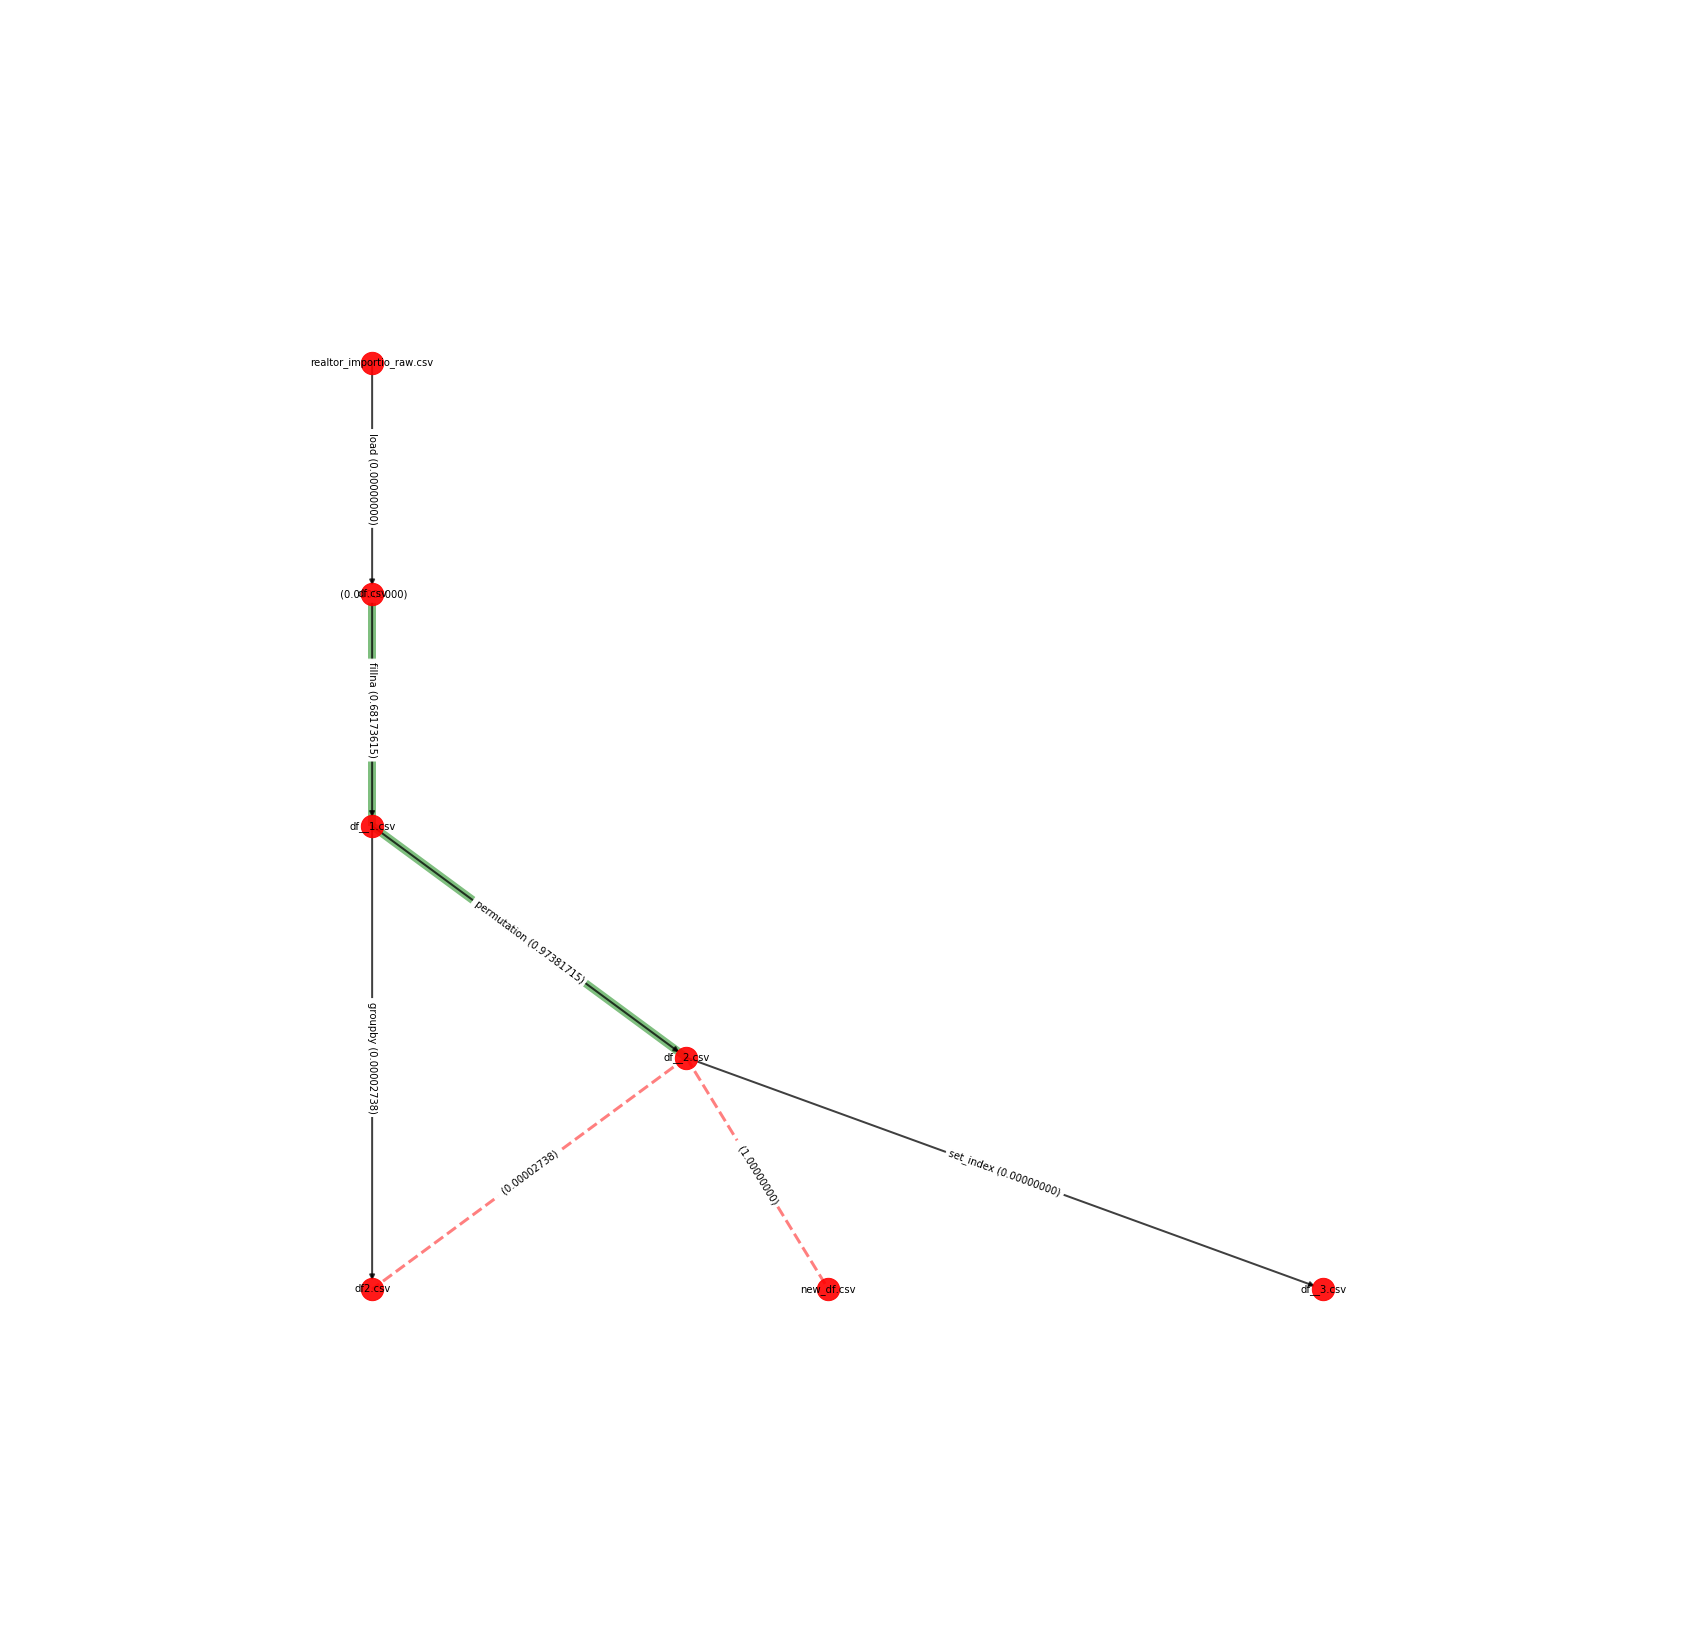

nb_495072
None

committees.csv
[('props.csv', 'prop.csv', {'operation': None, 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.10784313725490197}), ('merged.csv', 'oppose.csv', {'operation': None, 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.10825581395348838}), ('merged.csv', 'noncacontribs.csv', {'operation': None, 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.1941860465116279}), ('merged.csv', 'contribs.csv', {'inferred': True, 'correct': True, 'weight': 0.0012931191029419092}), ('support.csv', 'merged.csv', {'inferred': True, 'correct': True, 'weight': 0.8860465116279069})]


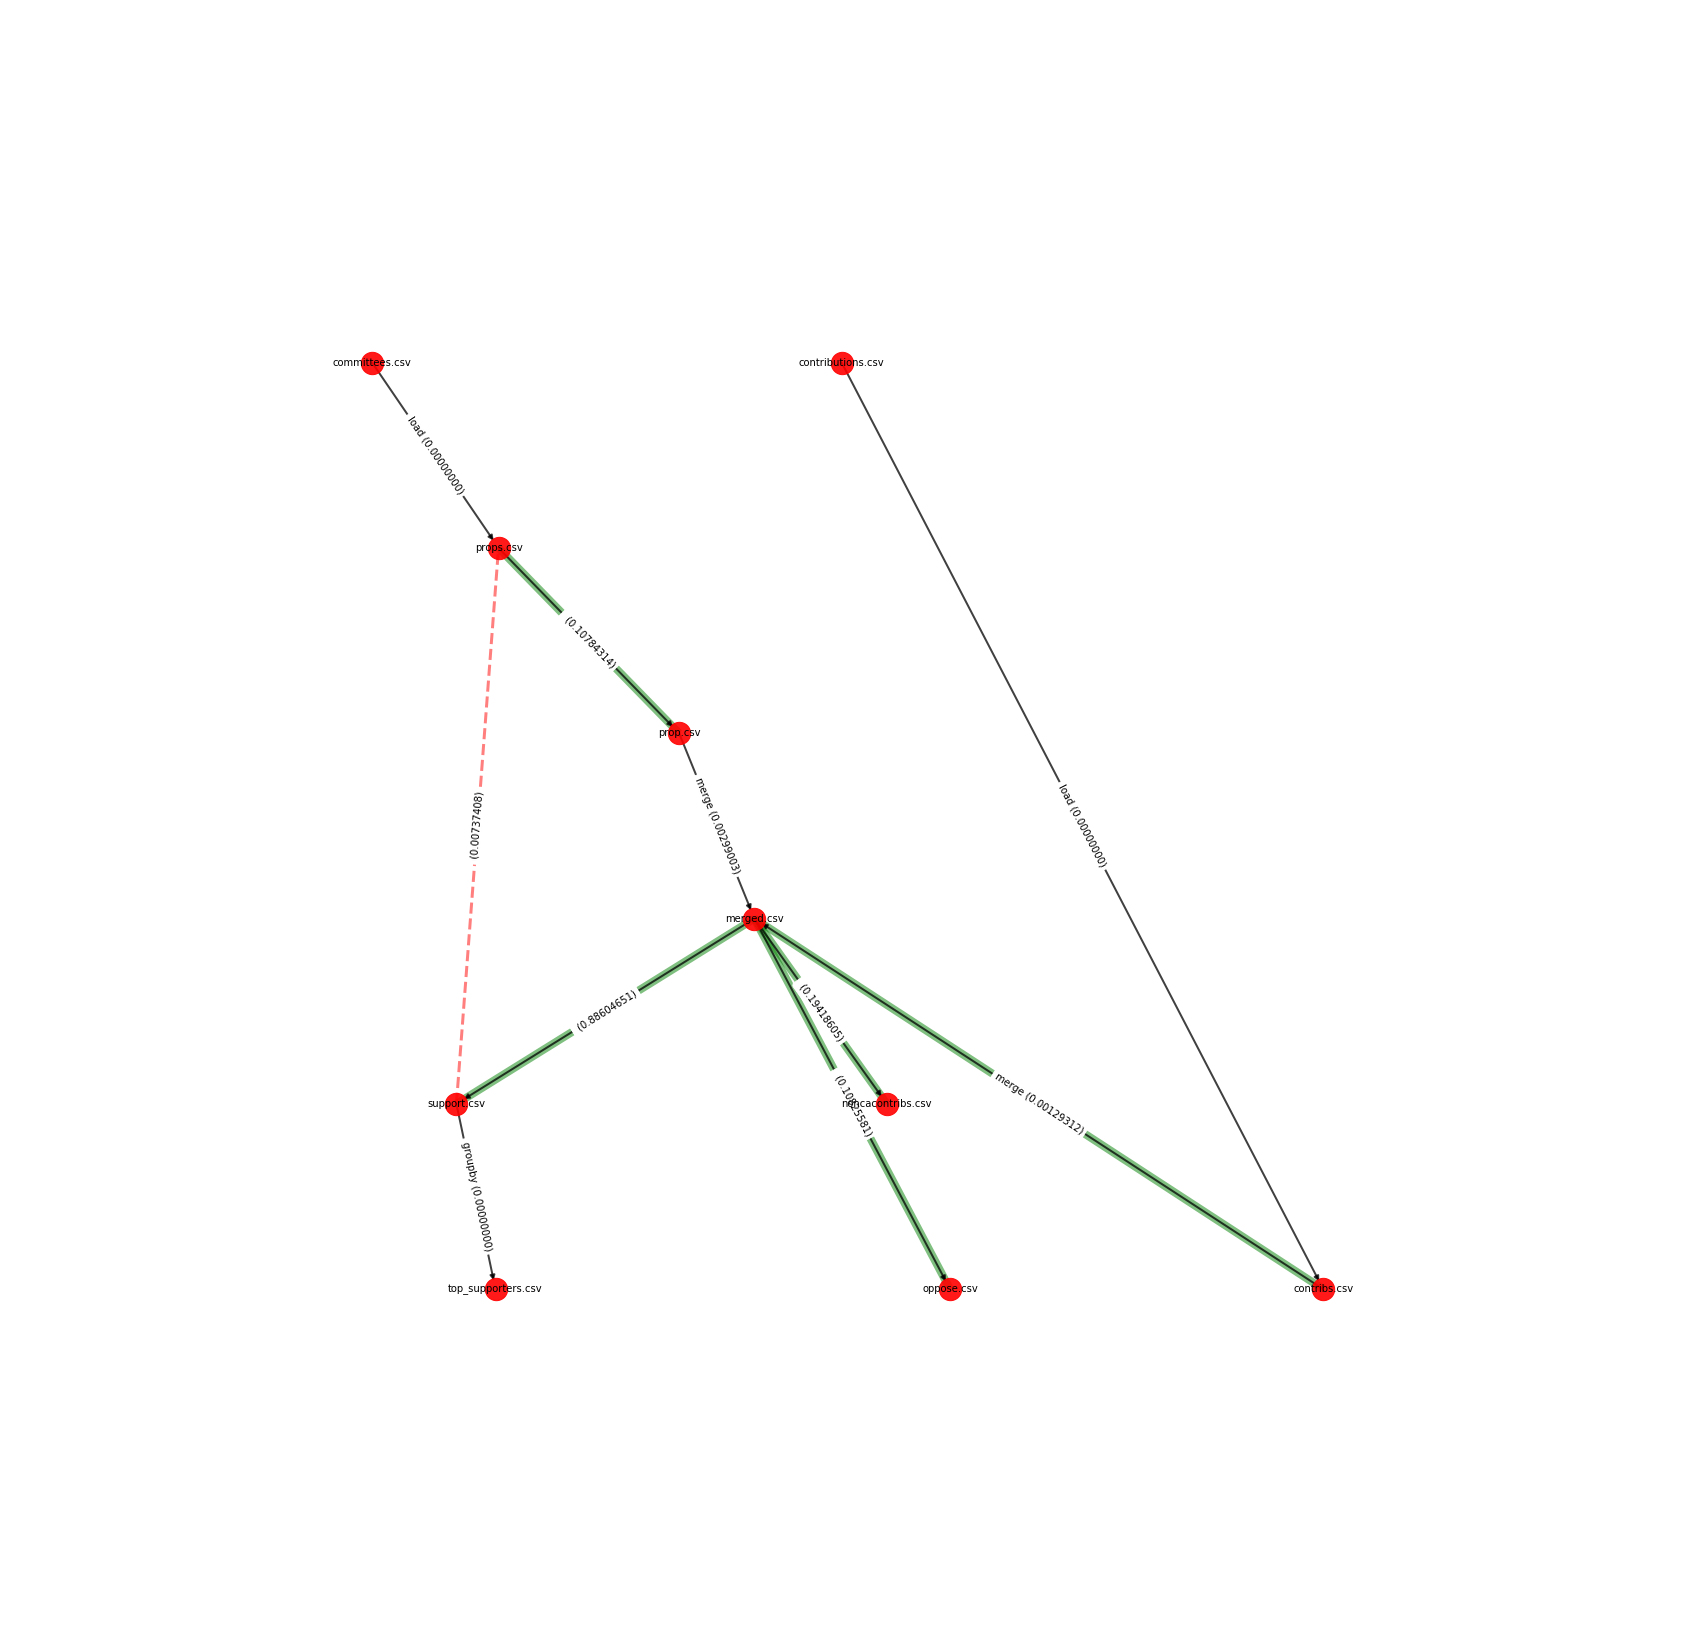

nb_315236
None

hs92_atlas.csv
[('HSdf__1.csv', 'AtlasHS.csv', {'operation': None, 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.9158671586715867}), ('HSdf__1.csv', 'HSdf.csv', {'inferred': True, 'correct': True, 'weight': 0.8}), ('MexHS.csv', 'MexHS__1.csv', {'operation': None, 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.916267942583732}), ('MexHS.csv', 'products_mexico_prospedia.csv', {'inferred': True, 'correct': True, 'weight': 0.8888888888888888}), ('AtlasHS_WithNoMexican.csv', 'AtlasHSWithMexMerge.csv', {'inferred': True, 'correct': True, 'weight': 0.08783239323126511})]


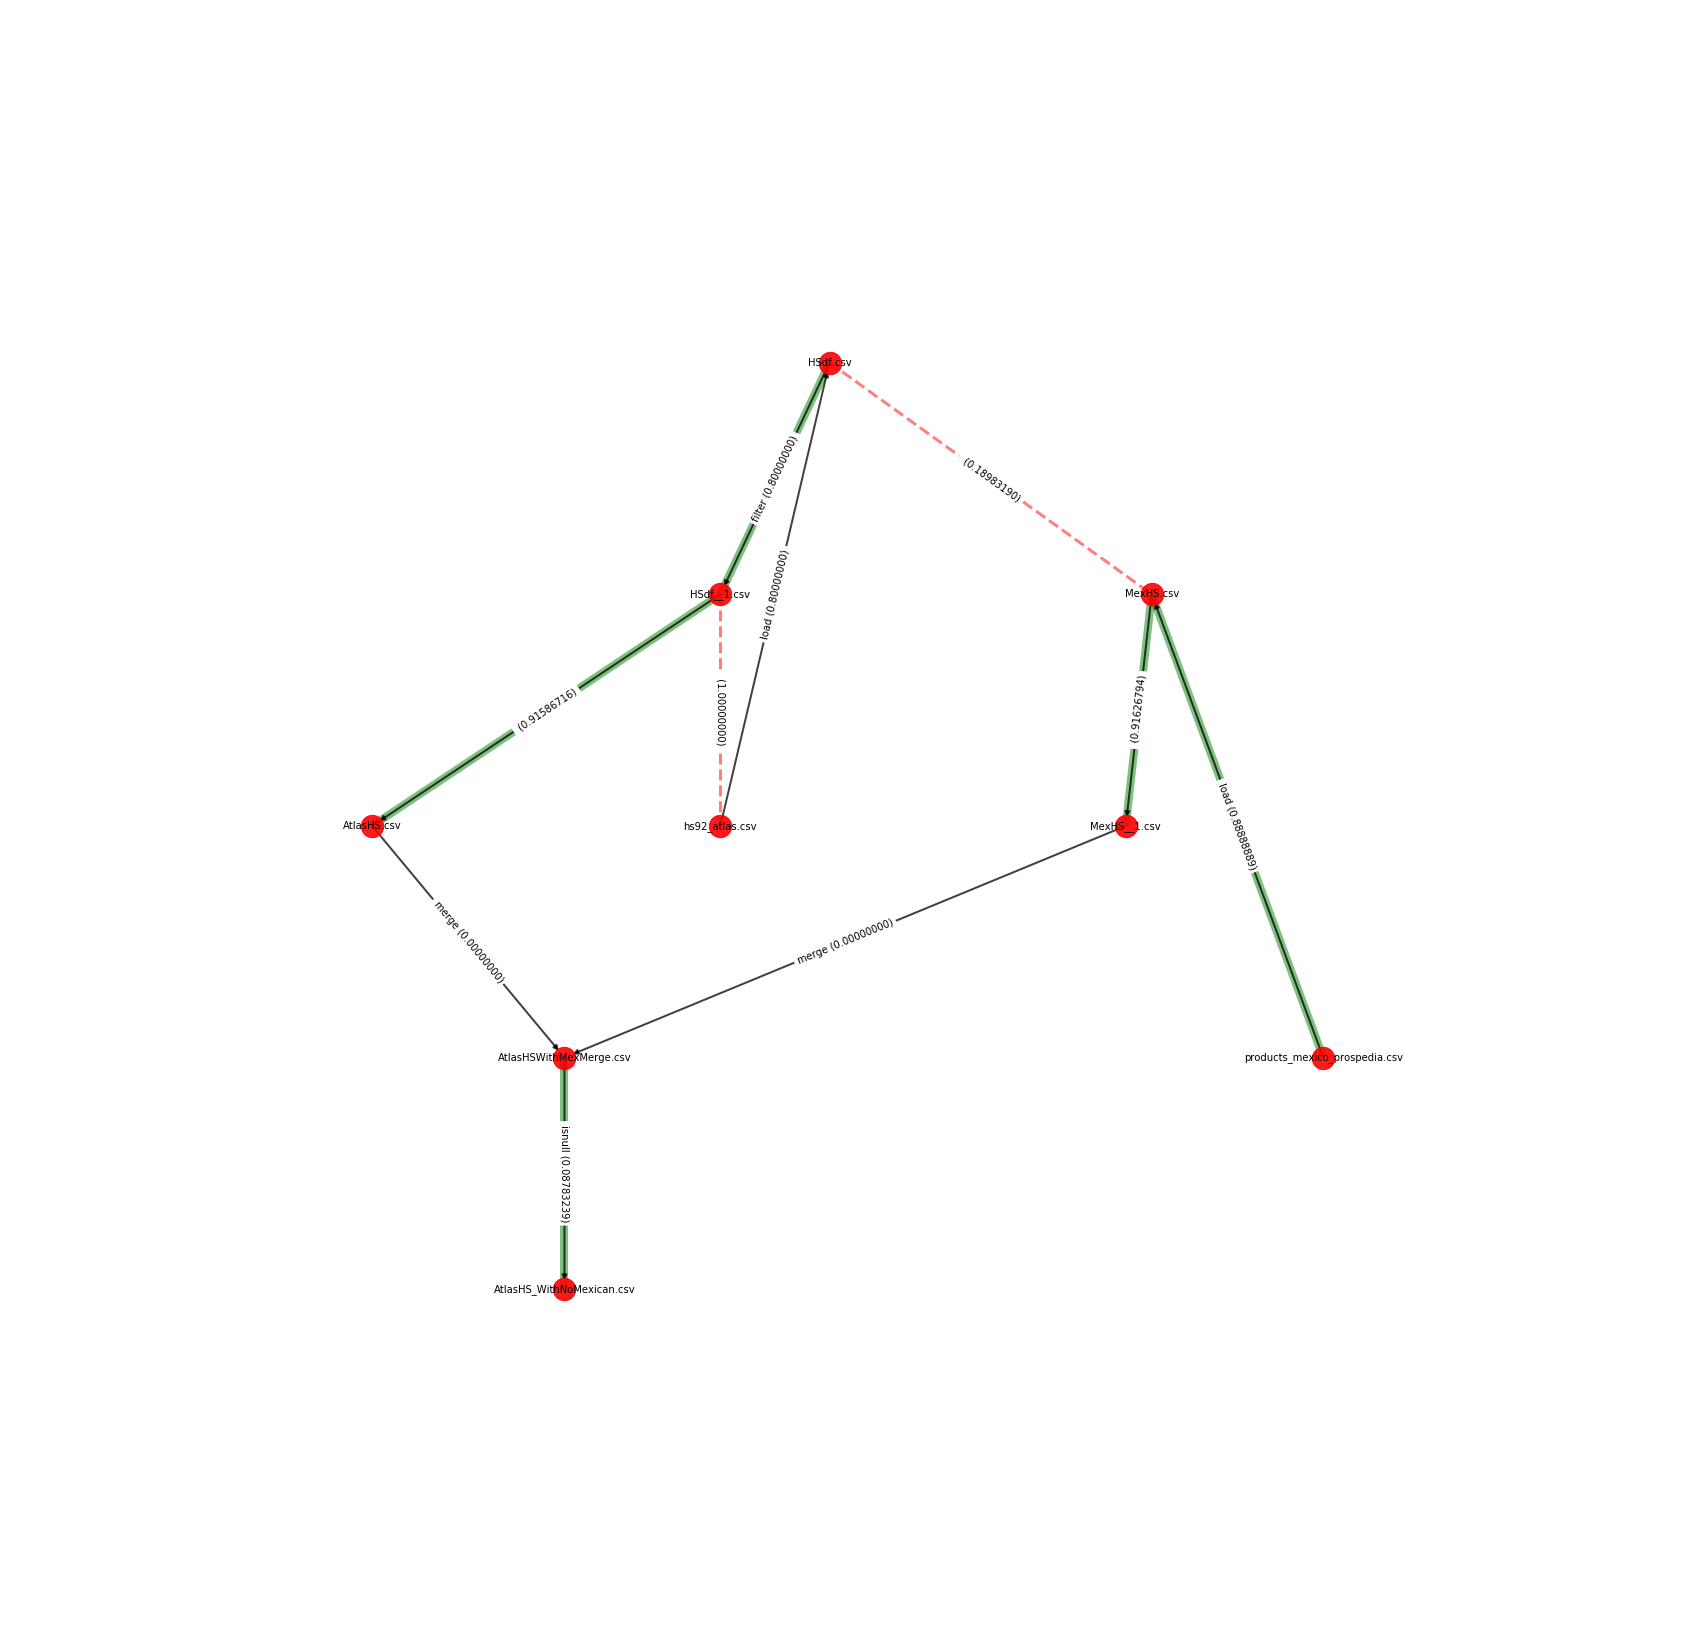

nb_484354
None

tdf__1.csv
[('df__1.csv', 'Salaries.csv', {'inferred': True, 'correct': True, 'weight': 0.3982412060301507}), ('tdf.csv', 'HairEyeColor.csv', {'inferred': True, 'correct': True, 'weight': 0.4090909090909091}), ('edf__1.csv', 'edf__2.csv', {'operation': None, 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.5}), ('edf__1.csv', 'Soils.csv', {'inferred': True, 'correct': True, 'weight': 0.2346938775510204})]


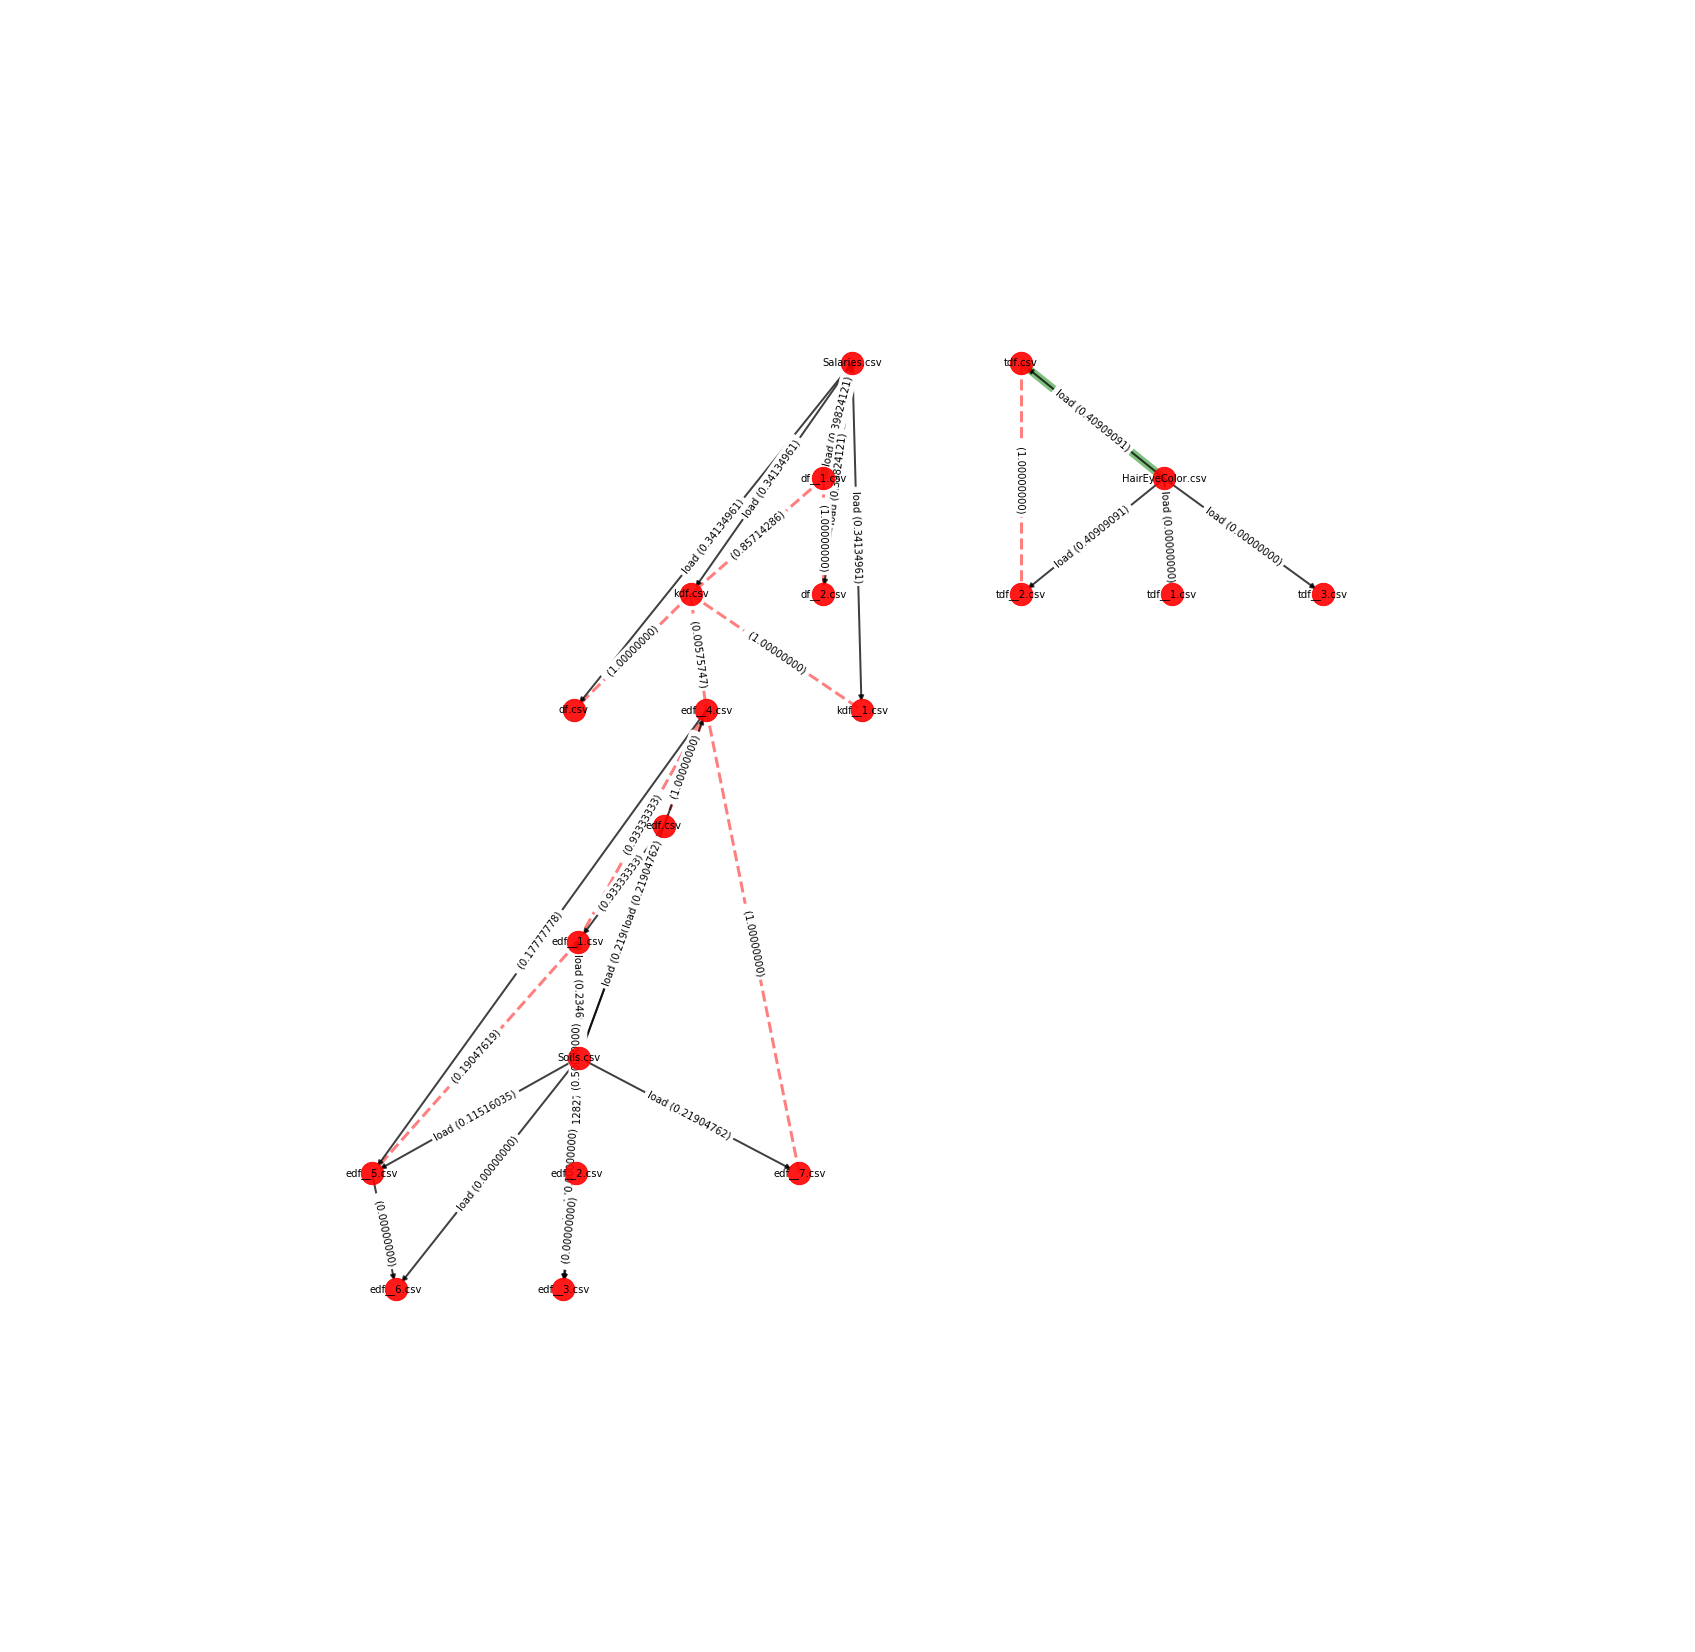

nb_772851
nb_924102
nb_921915
nb_986282
None

tmp.csv
[('winners2.csv', 'winners.csv', {'inferred': True, 'correct': True, 'weight': 1.0}), ('sub1.csv', 'sub_df.csv', {'operation': 'merge', 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.05882352941176471})]


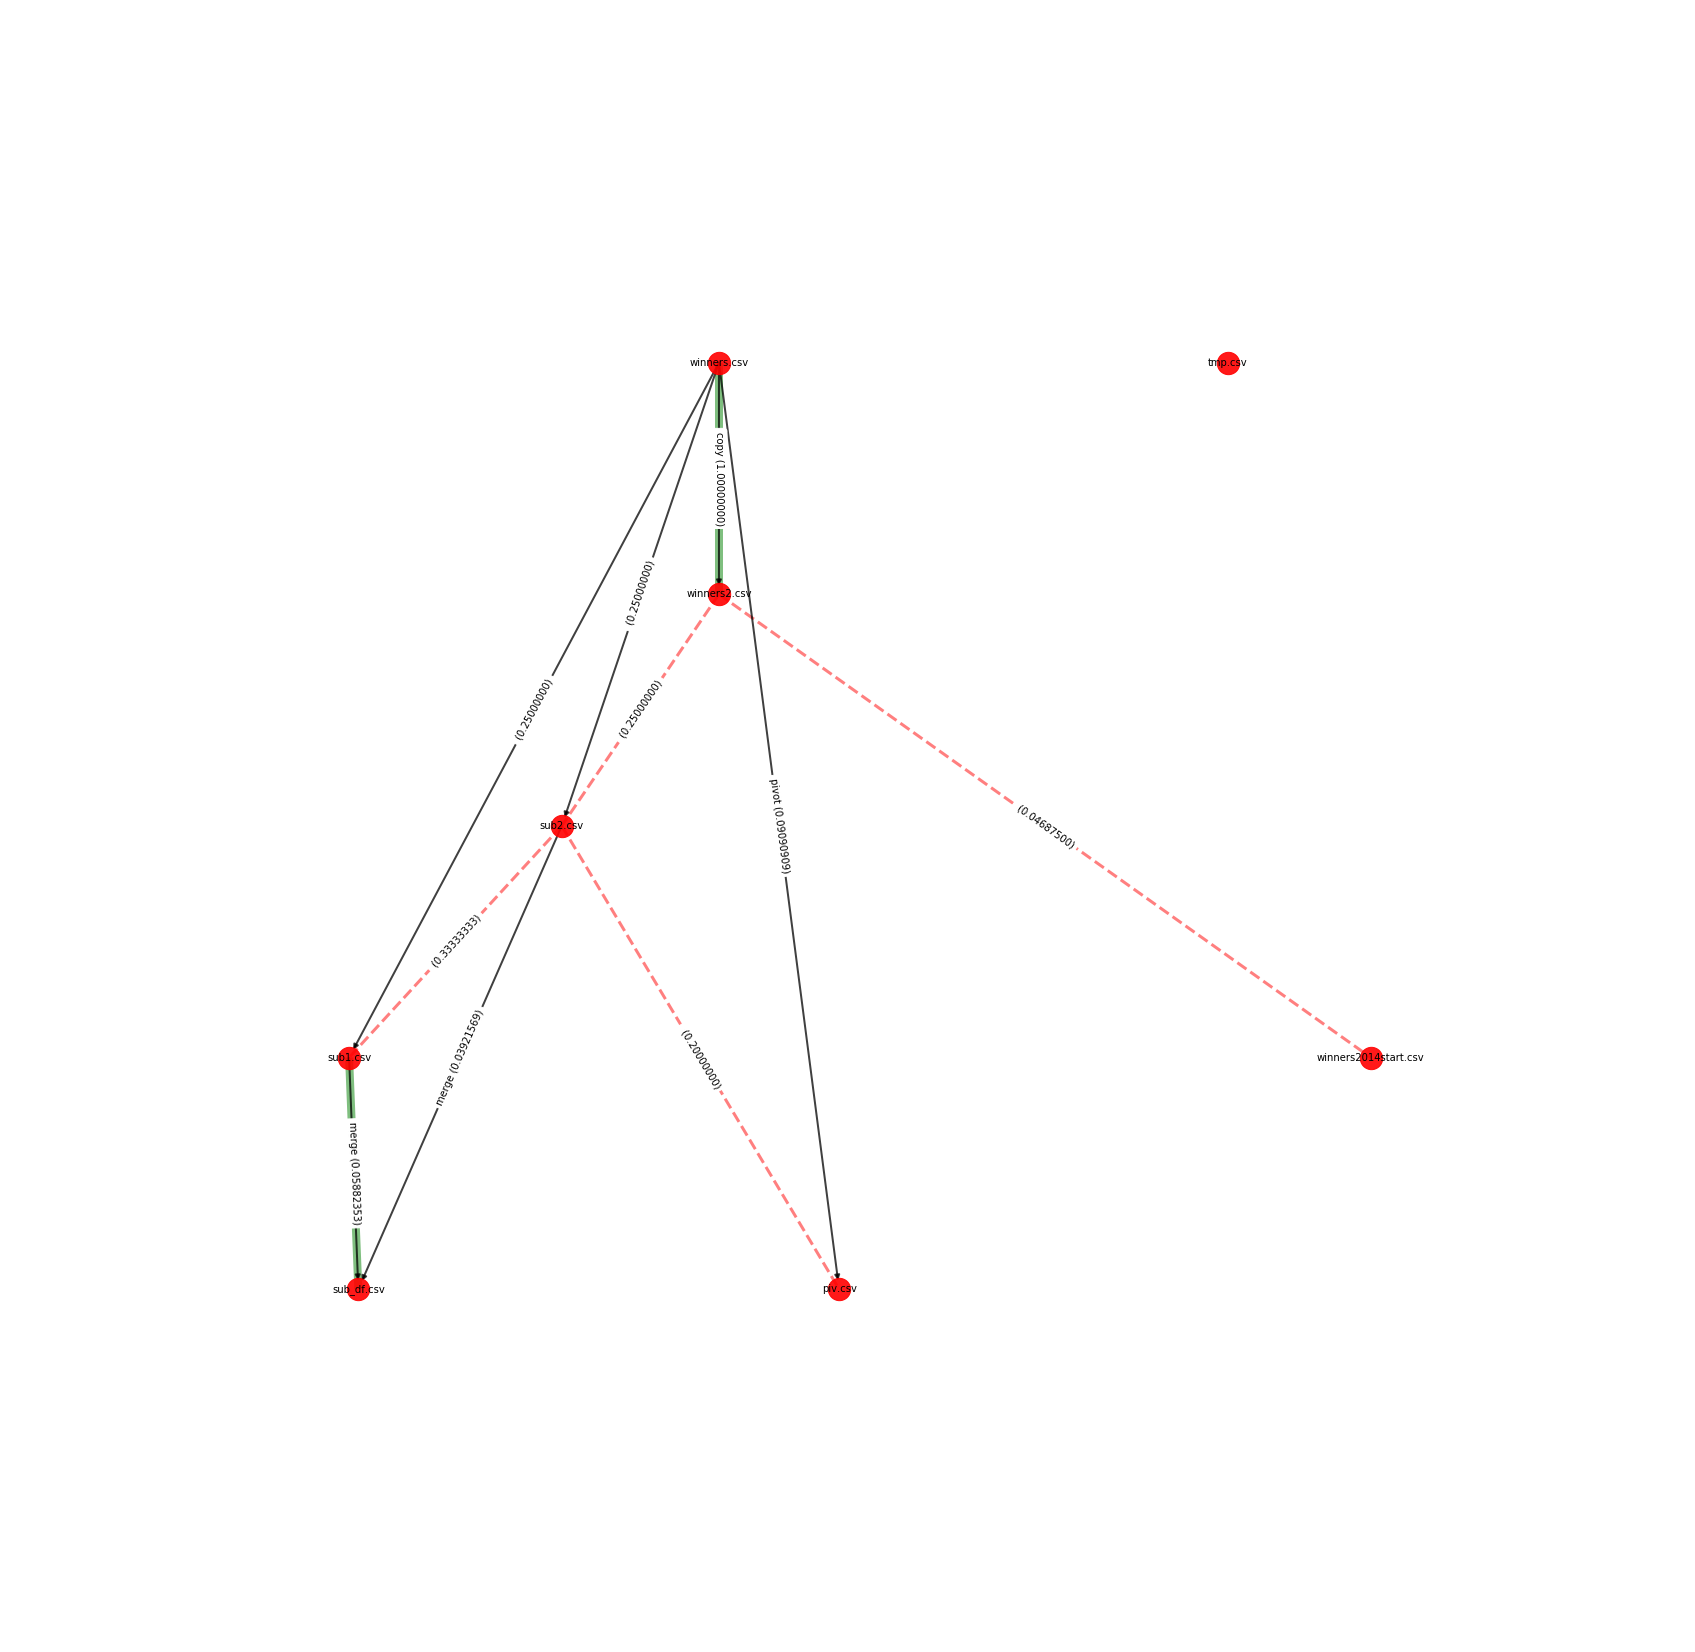

nb_639263
None

UNdata_Export_20170628_003608818.csv
[('w.csv', 'df.csv', {'operation': 'DataFrame', 'truth': True, 'inferred': True, 'correct': True, 'weight': 1.0})]


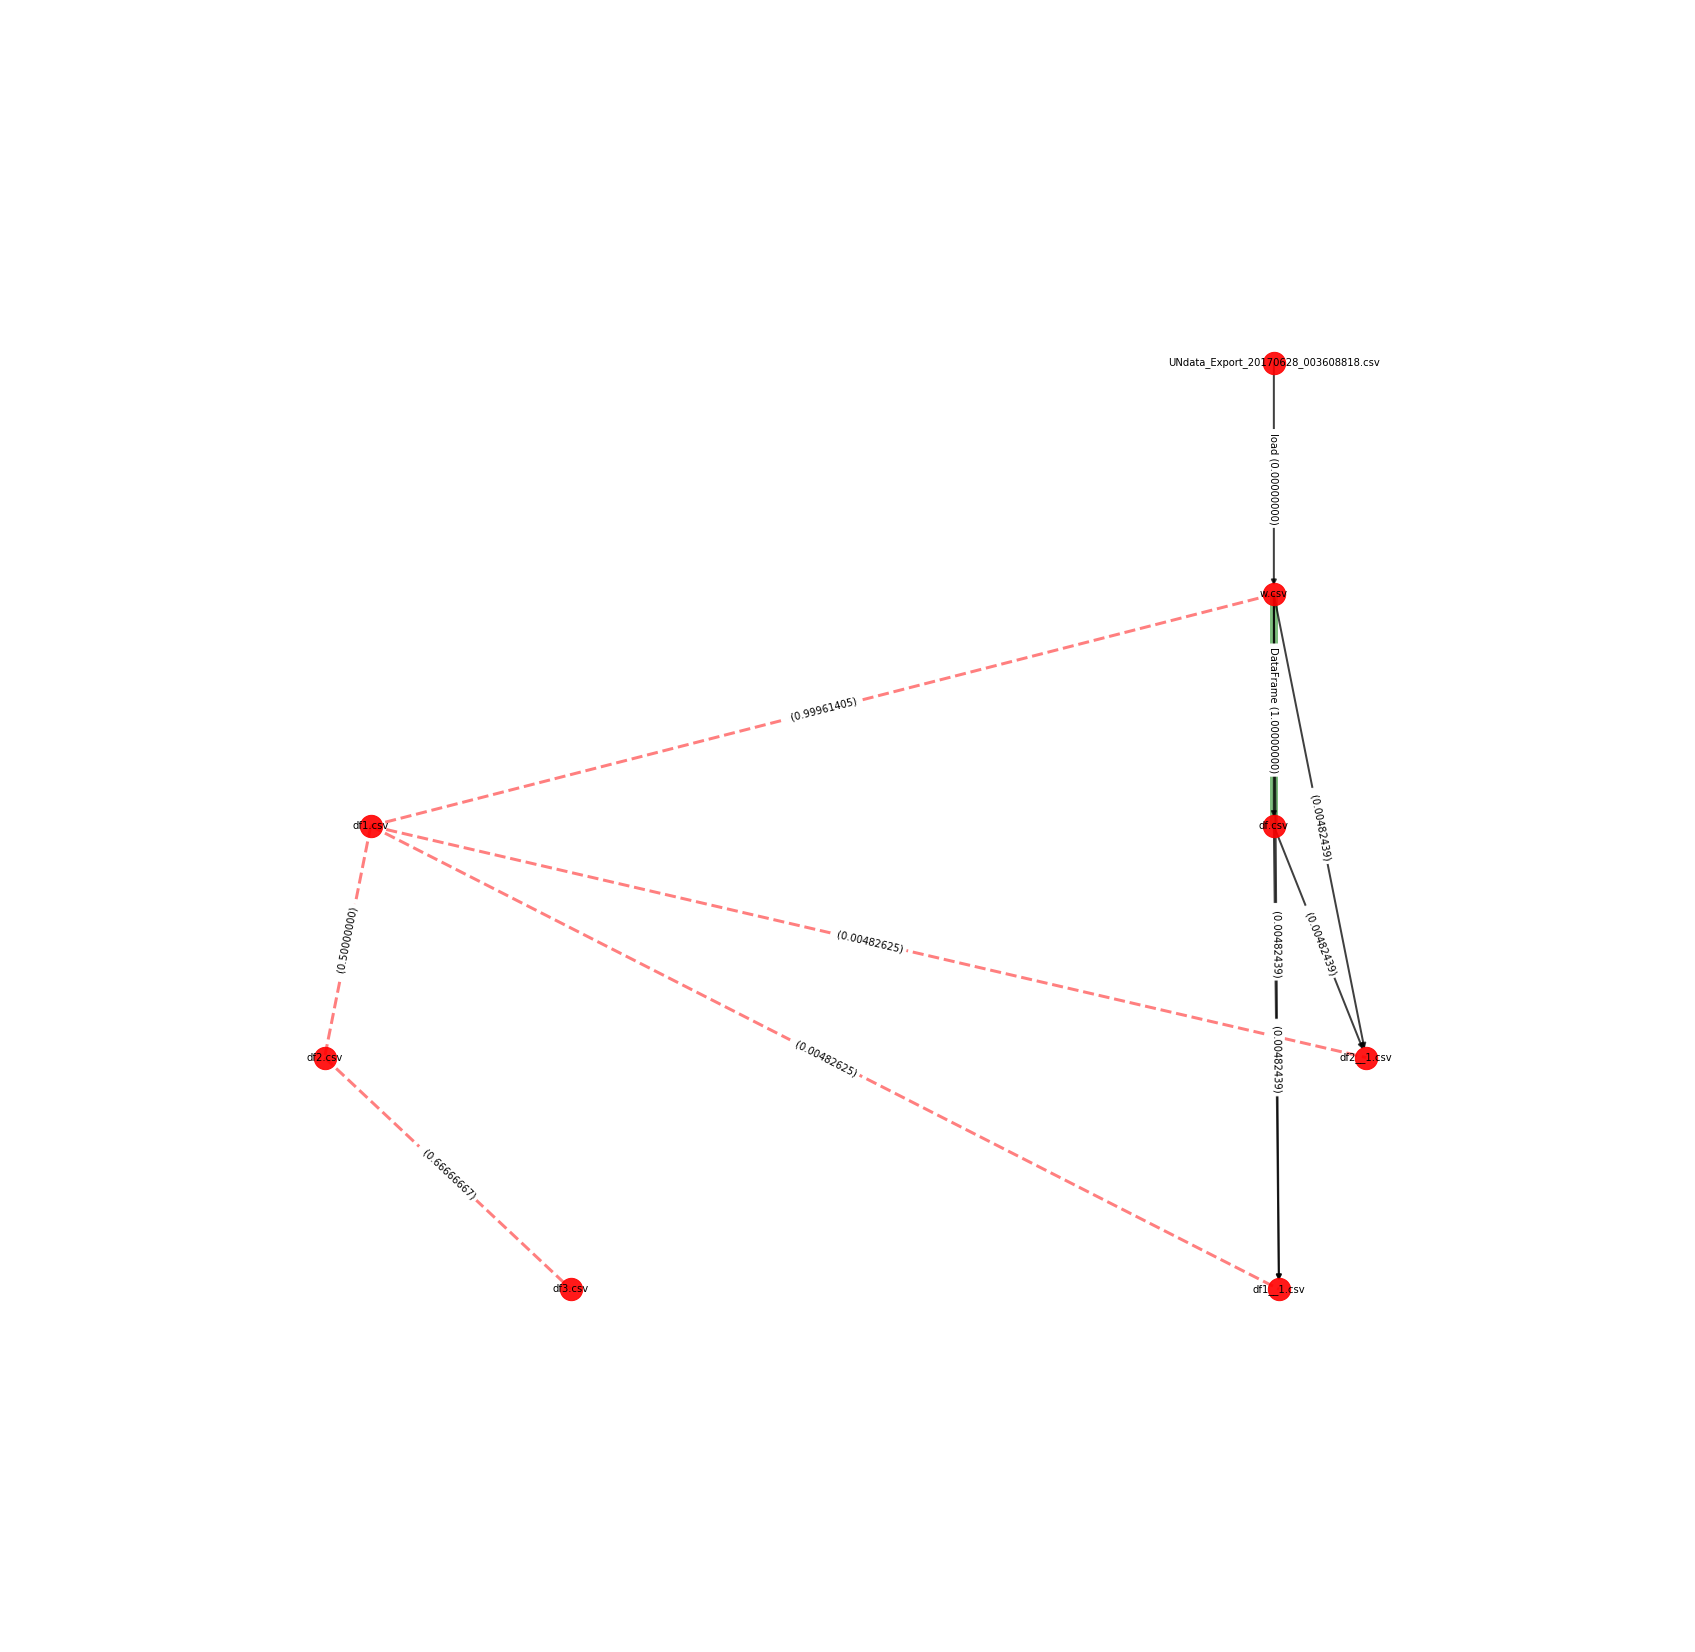

In [60]:
for nb in nb_list:
    try:
        print(nb)
        generate_and_draw_graph(nb+'.ipynb','cell')
    except:
        pass

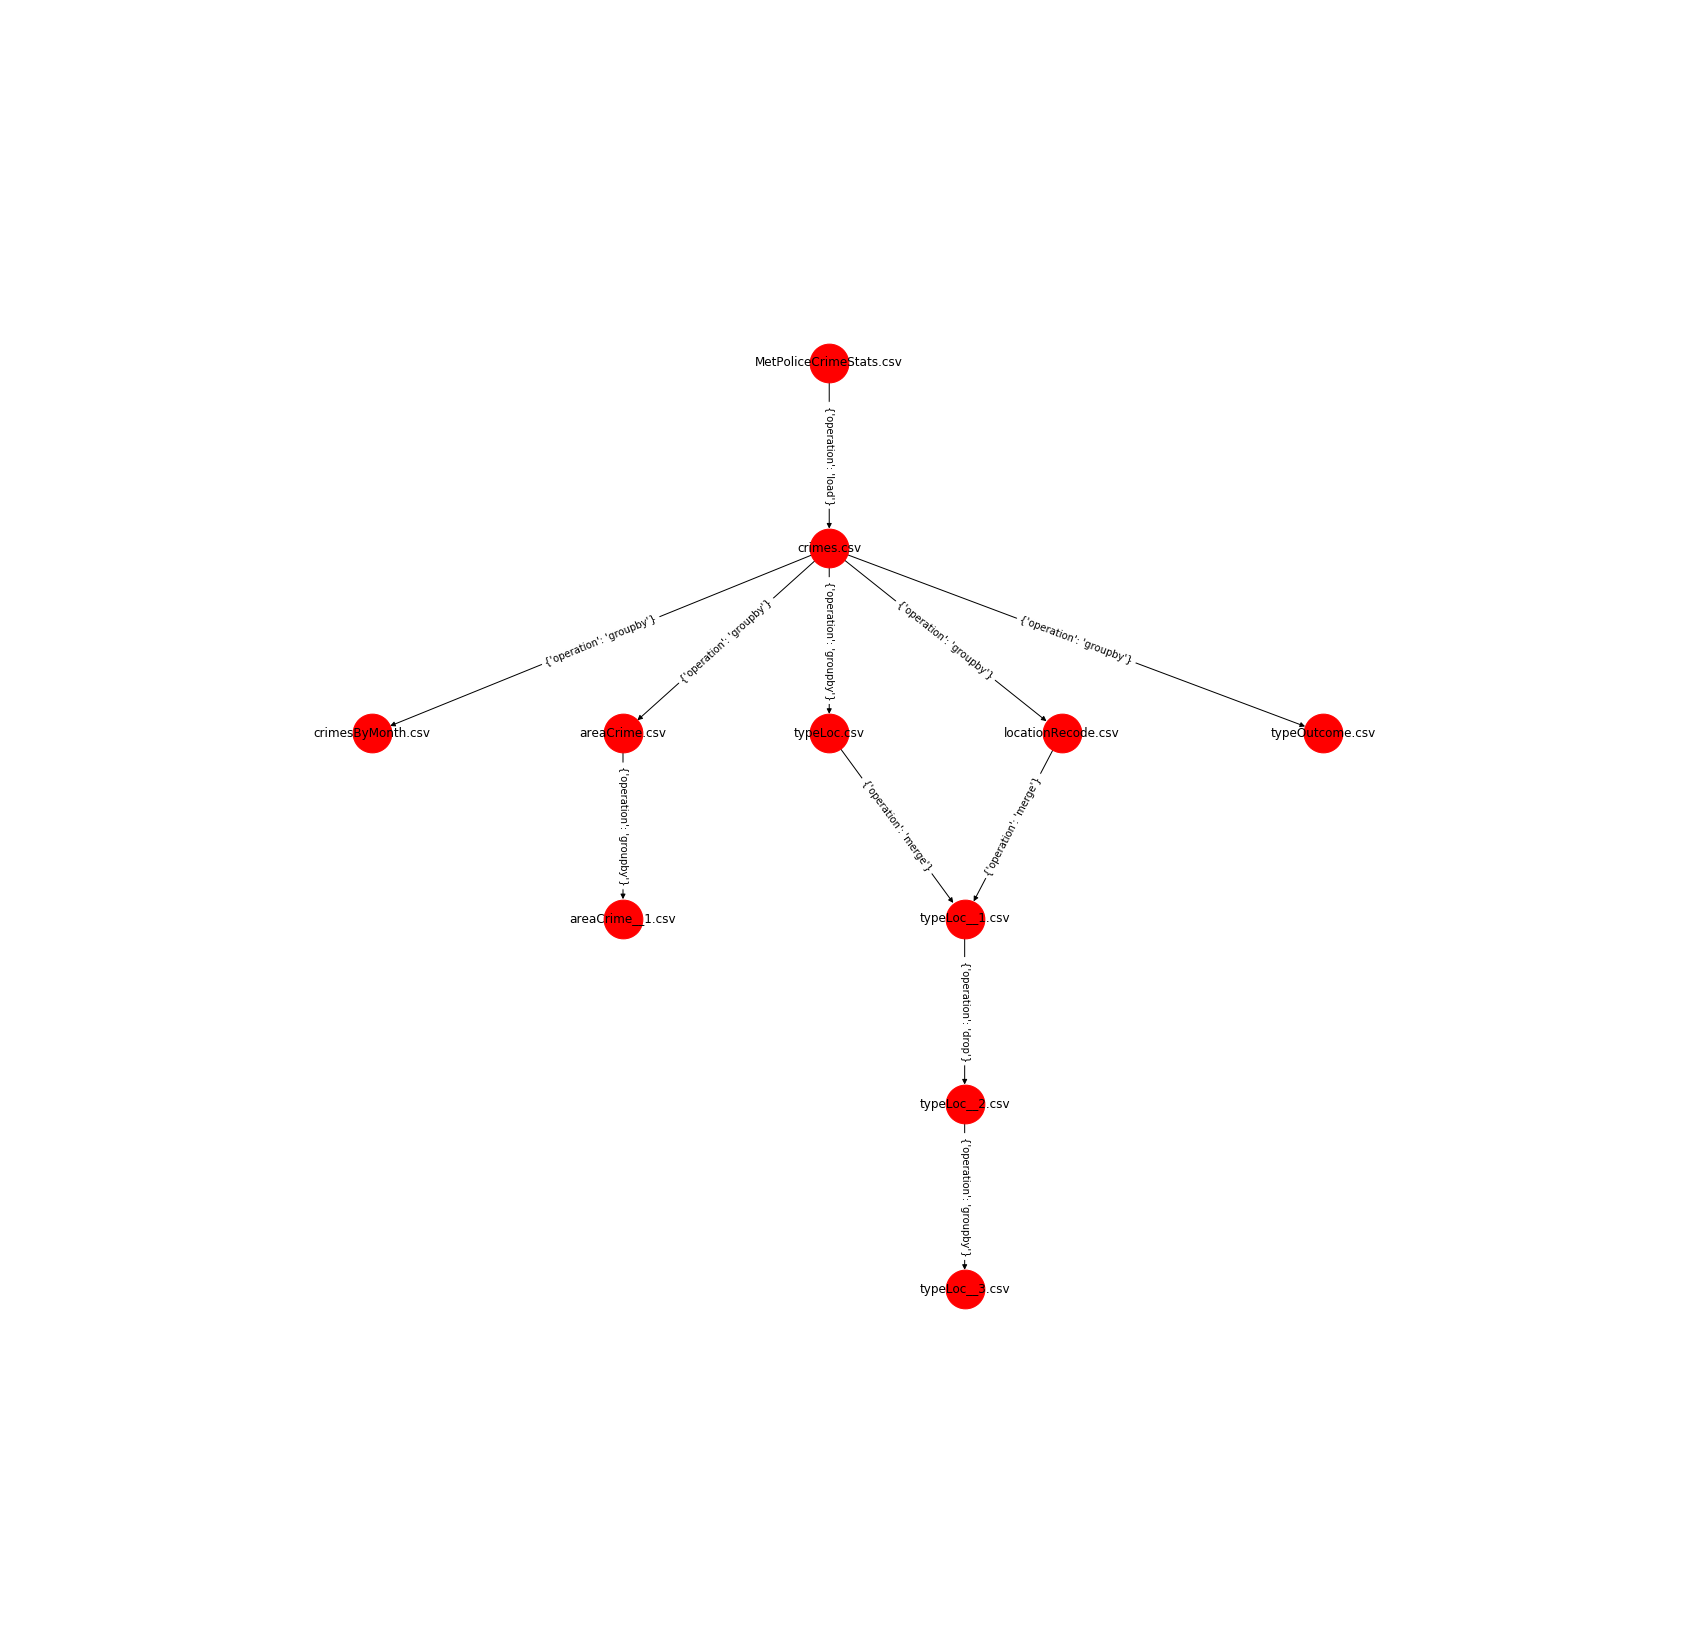

In [57]:
g = display_notebook('nb_331056.ipynb')

None

crimesByMonth.csv
[('MetPoliceCrimeStats.csv', 'crimes.csv', {'operation': 'load', 'truth': True, 'inferred': True, 'correct': True, 'weight': 1.0}), ('typeLoc.csv', 'typeLoc__1.csv', {'operation': 'merge', 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.8333333333333334}), ('typeLoc__1.csv', 'locationRecode.csv', {'inferred': True, 'correct': True, 'weight': 0.016988062442607896}), ('typeLoc__2.csv', 'typeLoc__3.csv', {'operation': 'groupby', 'truth': True, 'inferred': True, 'correct': True, 'weight': 0.03112947658402204})]


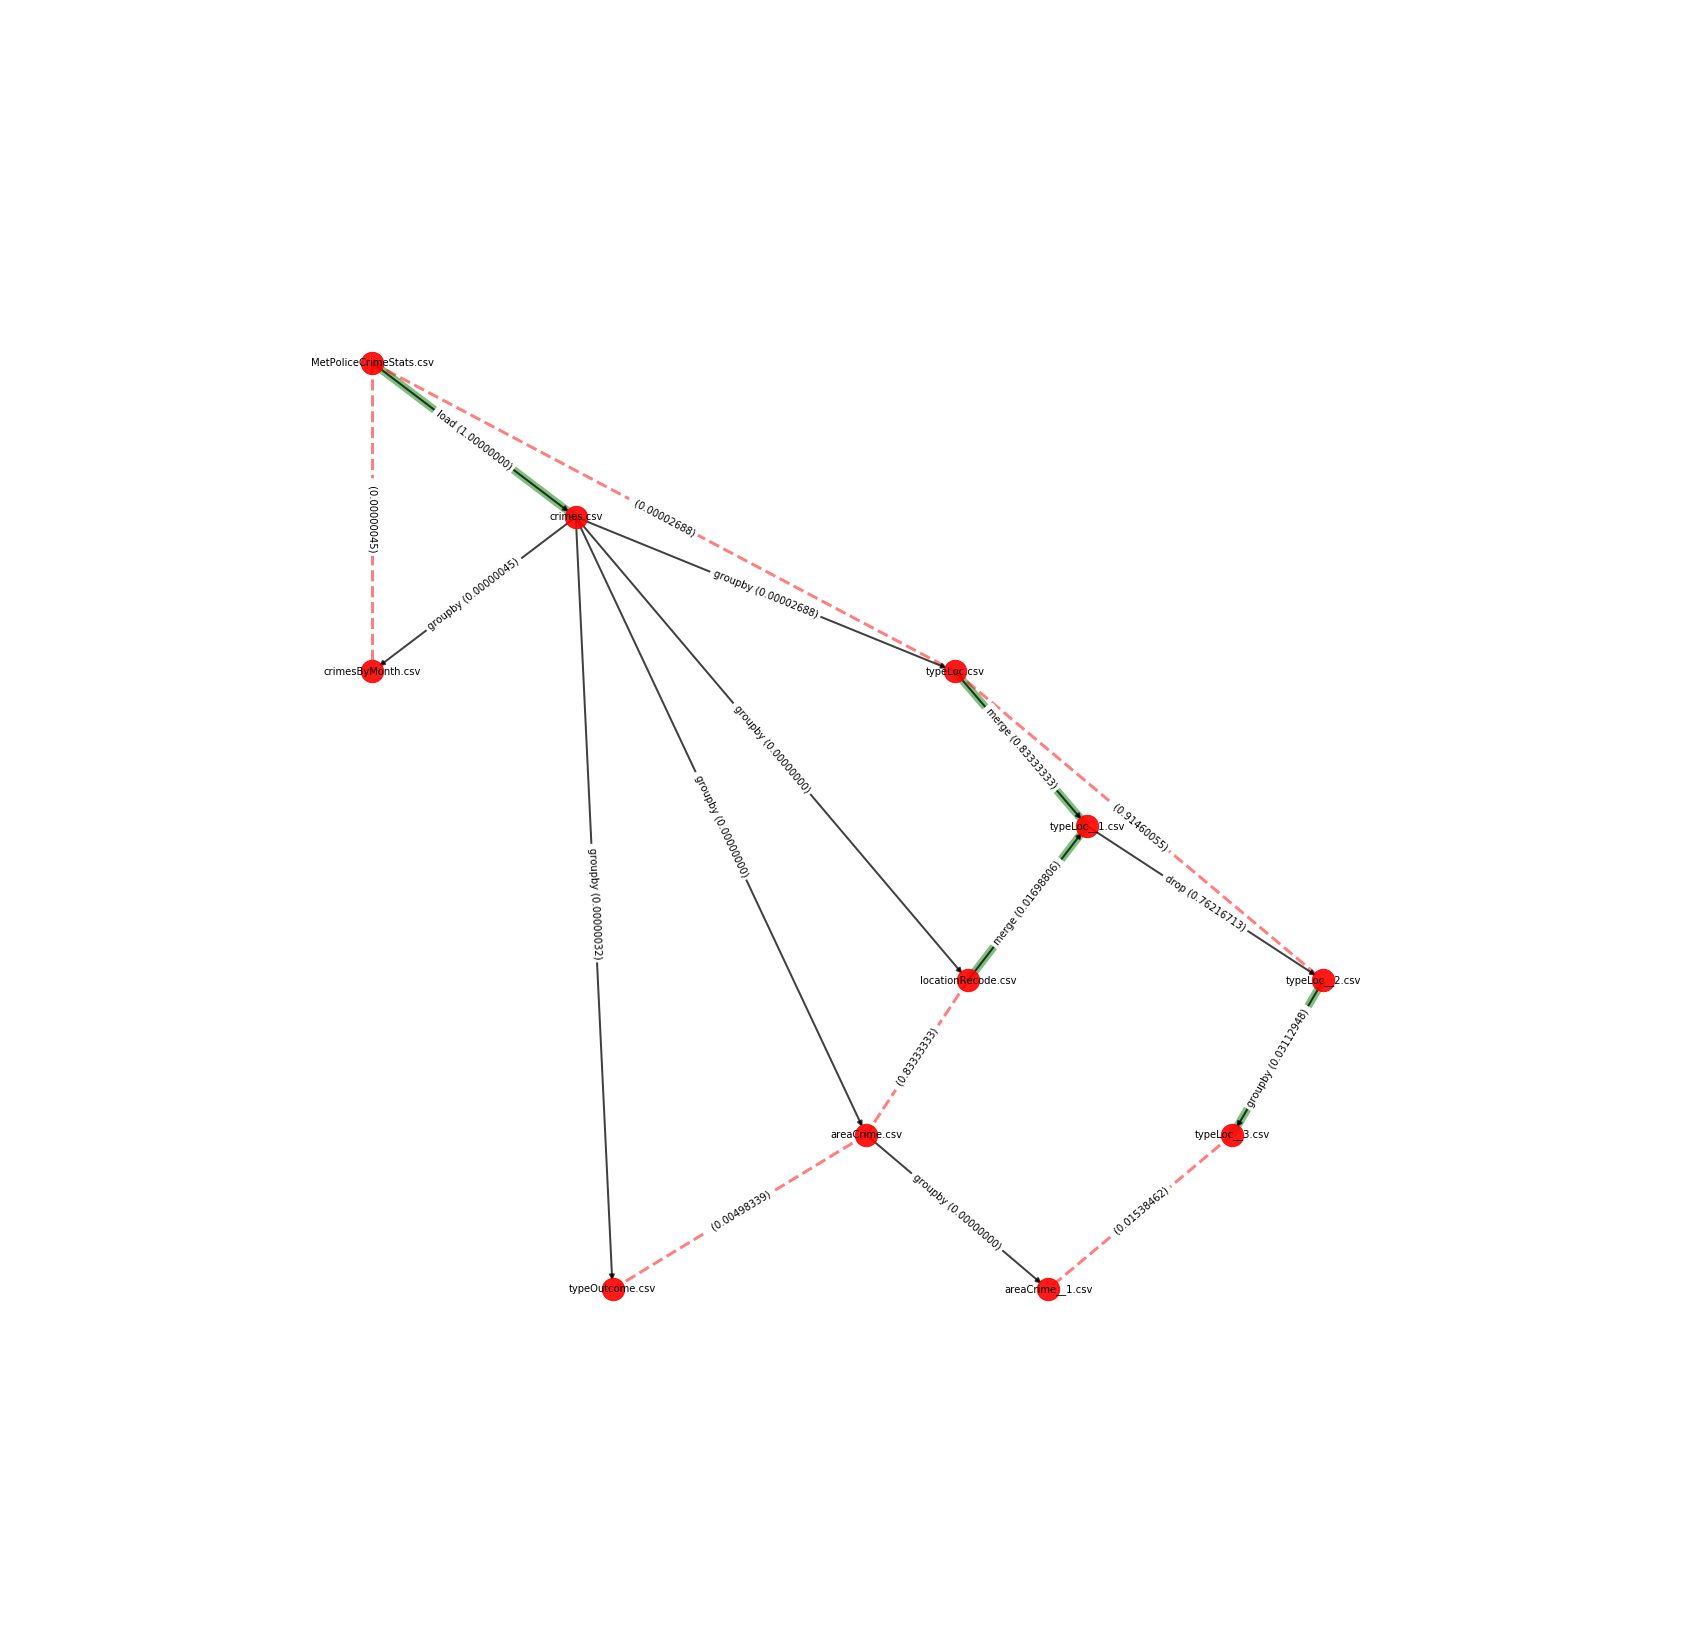

In [58]:
generate_and_draw_graph('nb_331056.ipynb', 'cell', root='MetPoliceCrimeStats.csv')

In [5]:
import glob
import os

base_dir = '/media/suhail/Data/experiments/reexec/res/'


def summarize_dataframe(nb_name, csvfile):
    df1 = pd.read_csv(csvfile, index_col=0)
    rows, cols = df1.shape
    schema = set(df1.columns)
    display(csvfile)
    pd.set_option('display.max_colwidth', -1)
    display(df1.head())
    return {'nb_name': nb_name,
            'csvfile':os.path.basename(csvfile), 
            'rows': rows,
            'cols': cols, 
            'schema': schema}


def dataframe_table(nb_file):
    artifact_dir = base_dir+nb_file+'/artifacts/'
    summary = []
    for csvfile in glob.glob(artifact_dir+'*.csv'):
        summary.append(summarize_dataframe(nb_file, csvfile))
    return pd.DataFrame(summary, columns=('nb_name',
                                          'csvfile',
                                          'rows',
                                          'schema'))
        
        
def compare_file_pairs(nb_file, file1, file2):
    artifact_dir = base_dir+nb_file+'/artifacts/'
    df1 = pd.read_csv(artifact_dir+file1, index_col=0)
    df2 = pd.read_csv(artifact_dir+file2, index_col=0)
    display(df1.head())
    display(df2.head())
    return similarity.compute_jaccard_DF_index(df1,df2)


def get_dataframe(nb_file, file):
    artifact_dir = base_dir+nb_file+'/artifacts/'
    return pd.read_csv(artifact_dir+file, index_col=0)


In [210]:
compare_file_pairs('nb_331056.ipynb', 'crimes.csv', 'crimesByMonth.csv')


,Outcome Month,Outcome type,Crime Month,Crime type,Area
0,2016-01,Court case unable to proceed,2016-01,Violence and sexual offences,Enfield
3,2016-01,Investigation complete; no suspect identified,2016-01,Criminal damage and arson,Lambeth
4,2016-01,Investigation complete; no suspect identified,2016-01,Theft from the person,Lambeth
5,2016-01,Investigation complete; no suspect identified,2016-01,Violence and sexual offences,Lambeth
6,2016-01,Investigation complete; no suspect identified,2016-01,Theft from the person,Lambeth


,Crime Month,Outcome Month,Outcome type,Crime type,Area
0,2016-01,40293,40293,40293,40293
1,2016-02,39376,39376,39376,39376
2,2016-03,40524,40524,40524,40524
3,2016-04,39700,39700,39700,39700
4,2016-05,42753,42753,42753,42753


4.4825661794864326e-07

In [62]:
pd.set_option('display.max_colwidth', -1)
dataframe_table('nb_331056.ipynb')

'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/typeLoc__1.csv'

,Crime type,Area,Outcome Month,Outcome type,Crime Month,Recoded Area
0,Bicycle theft,Barking and Dagenham,87,87,87,Barking and Dagenham
1,Bicycle theft,Barnet,106,106,106,Barnet
2,Bicycle theft,Bexley,77,77,77,Bexley
3,Bicycle theft,Brent,196,196,196,Brent
4,Bicycle theft,Bromley,102,102,102,Bromley


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/typeLoc.csv'

,Crime type,Area,Outcome Month,Outcome type,Crime Month
0,Bicycle theft,Barking and Dagenham,87,87,87
1,Bicycle theft,Barnet,106,106,106
2,Bicycle theft,Bexley,77,77,77
3,Bicycle theft,Brent,196,196,196
4,Bicycle theft,Bromley,102,102,102


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/areaCrime.csv'

,Area,Outcome Month,Outcome type,Crime Month,Crime type
0,Adur,1,1,1,1
1,Ashford,1,1,1,1
2,Aylesbury Vale,1,1,1,1
3,Babergh,1,1,1,1
4,Barking and Dagenham,10401,10401,10401,10401


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/locationRecode.csv'

,Area,Outcome Month,Outcome type,Crime Month,Crime type,Recoded Area
0,Adur,1,1,1,1,Not in London
1,Ashford,1,1,1,1,Not in London
2,Aylesbury Vale,1,1,1,1,Not in London
3,Babergh,1,1,1,1,Not in London
4,Barking and Dagenham,10401,10401,10401,10401,Barking and Dagenham


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/areaCrime__1.csv'

,Area,Outcome Month,Outcome type,Crime Month,Crime type
0,Barking and Dagenham,10401,10401,10401,10401
1,Barnet,14321,14321,14321,14321
2,Bexley,7837,7837,7837,7837
3,Brent,15911,15911,15911,15911
4,Bromley,12499,12499,12499,12499


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/crimesByMonth.csv'

,Crime Month,Outcome Month,Outcome type,Crime type,Area
0,2016-01,40293,40293,40293,40293
1,2016-02,39376,39376,39376,39376
2,2016-03,40524,40524,40524,40524
3,2016-04,39700,39700,39700,39700
4,2016-05,42753,42753,42753,42753


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/MetPoliceCrimeStats.csv'

,Outcome Month,Outcome type,Crime Month,Crime type,Area
0,2016-01,Court case unable to proceed,2016-01,Violence and sexual offences,Enfield
3,2016-01,Investigation complete; no suspect identified,2016-01,Criminal damage and arson,Lambeth
4,2016-01,Investigation complete; no suspect identified,2016-01,Theft from the person,Lambeth
5,2016-01,Investigation complete; no suspect identified,2016-01,Violence and sexual offences,Lambeth
6,2016-01,Investigation complete; no suspect identified,2016-01,Theft from the person,Lambeth


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/typeLoc__2.csv'

,Crime type,Outcome Month,Outcome type,Crime Month,Area
0,Bicycle theft,87,87,87,Barking and Dagenham
1,Bicycle theft,106,106,106,Barnet
2,Bicycle theft,77,77,77,Bexley
3,Bicycle theft,196,196,196,Brent
4,Bicycle theft,102,102,102,Bromley


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/typeOutcome.csv'

,Crime type,Broad Outcome,Outcome Month,Outcome type,Crime Month,Area,text
0,Bicycle theft,Defendant found not guilty,1,1,1,1,<b>Bicycle theft</b><br>Defendant found not guilty<br>1
1,Bicycle theft,No judicial outcome,8128,8128,8128,8128,"<b>Bicycle theft</b><br>No judicial outcome<br>8,128"
2,Bicycle theft,Offender sent to prison,7,7,7,7,<b>Bicycle theft</b><br>Offender sent to prison<br>7
3,Bicycle theft,Outcome not yet known,272,272,272,272,<b>Bicycle theft</b><br>Outcome not yet known<br>272
4,Bicycle theft,"Punished, not prison",123,123,123,123,"<b>Bicycle theft</b><br>Punished, not prison<br>123"


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/crimes.csv'

,Outcome Month,Outcome type,Crime Month,Crime type,Area
0,2016-01,Court case unable to proceed,2016-01,Violence and sexual offences,Enfield
3,2016-01,Investigation complete; no suspect identified,2016-01,Criminal damage and arson,Lambeth
4,2016-01,Investigation complete; no suspect identified,2016-01,Theft from the person,Lambeth
5,2016-01,Investigation complete; no suspect identified,2016-01,Violence and sexual offences,Lambeth
6,2016-01,Investigation complete; no suspect identified,2016-01,Theft from the person,Lambeth


'/media/suhail/Data/experiments/reexec/res/nb_331056.ipynb/artifacts/typeLoc__3.csv'

,Crime type,Area,Outcome Month,Outcome type,Crime Month
0,Bicycle theft,Barking and Dagenham,87,87,87
1,Bicycle theft,Barnet,106,106,106
2,Bicycle theft,Bexley,77,77,77
3,Bicycle theft,Brent,196,196,196
4,Bicycle theft,Bromley,102,102,102


,nb_name,csvfile,rows,schema
0,nb_331056.ipynb,typeLoc__1.csv,726,"{Outcome type, Recoded Area, Crime Month, Crime type, Area, Outcome Month}"
1,nb_331056.ipynb,typeLoc.csv,726,"{Outcome type, Crime Month, Crime type, Area, Outcome Month}"
2,nb_331056.ipynb,areaCrime.csv,172,"{Outcome type, Crime Month, Crime type, Area, Outcome Month}"
3,nb_331056.ipynb,locationRecode.csv,172,"{Outcome type, Recoded Area, Crime Month, Crime type, Area, Outcome Month}"
4,nb_331056.ipynb,areaCrime__1.csv,33,"{Outcome type, Crime Month, Crime type, Area, Outcome Month}"
5,nb_331056.ipynb,crimesByMonth.csv,12,"{Outcome type, Crime Month, Crime type, Area, Outcome Month}"
6,nb_331056.ipynb,MetPoliceCrimeStats.csv,446169,"{Outcome type, Crime Month, Crime type, Area, Outcome Month}"
7,nb_331056.ipynb,typeLoc__2.csv,726,"{Outcome type, Crime Month, Crime type, Area, Outcome Month}"
8,nb_331056.ipynb,typeOutcome.csv,65,"{Outcome type, text, Crime Month, Crime type, Broad Outcome, Area, Outcome Month}"
9,nb_331056.ipynb,crimes.csv,446169,"{Outcome type, Crime Month, Crime type, Area, Outcome Month}"


# Non-Point Preserving Prototypes
## GroupBy

In [45]:
# Non-Point Preserving Prototypes

# GroupBy detector test:
# Expects Pandas Series Objects
def column_groupby_check(col1, col2):
    # If the columns are same, return False
    #if len(col1) == len(col2):
    #    return False
    src, dst = ((col1,col2) if len(col1) > len(col2) else (col2, col1))
    if(set(src.values) == set(dst.values)): # Check set intersection
        if(len(set(src.values)) == len(dst.values)): # Check if destination set is unique and fully contained
            return True
    else:
        return False

In [128]:
df1 = get_dataframe('nb_331056.ipynb', 'typeLoc.csv')
df2 = get_dataframe('nb_331056.ipynb', 'locationRecode.csv')

col1 = df1['Crime Month']
col2 = df2['Crime Month']

column_groupby_check(col1, col2)

False

In [35]:
import itertools

def df_groupby_check(df1,df2):
    combinations = itertools.product(list(df1), list(df2))
    for col1,col2 in combinations:
        if(column_groupby_check(df1[col1], df2[col2])):
            return str(col1), str(col2)
    return False

In [36]:
df_groupby_check(df1,df2)

('Outcome Month', 'Crime Month')

In [47]:
test_nb = 'nb_331056.ipynb'

def get_all_groupbys_wf(nb_name):
    artifact_dir = base_dir+nb_name+'/artifacts/'
    artifacts = [os.path.basename(p) for p in glob.glob(artifact_dir+'*.csv')]
    df_dict = {artifact: get_dataframe(nb_name, artifact) for artifact in artifacts}
    combinations = itertools.combinations(df_dict.keys(),2)
    for df1, df2 in combinations:
        result = df_groupby_check(df_dict[df1], df_dict[df2])
        if result:
            print(df1, result[0], df2, result[1])
    return True
    

get_all_groupbys_wf(test_nb)

typeLoc__1.csv Area areaCrime.csv Area
typeLoc__1.csv Area locationRecode.csv Area
typeLoc__1.csv Recoded Area areaCrime__1.csv Area
typeLoc.csv Area areaCrime.csv Area
typeLoc.csv Area locationRecode.csv Area
areaCrime.csv Area locationRecode.csv Area
areaCrime.csv Area MetPoliceCrimeStats.csv Area
areaCrime.csv Area crimes.csv Area
locationRecode.csv Recoded Area areaCrime__1.csv Area
locationRecode.csv Area MetPoliceCrimeStats.csv Area
locationRecode.csv Area crimes.csv Area
areaCrime__1.csv Area typeLoc__2.csv Area
areaCrime__1.csv Area typeLoc__3.csv Area
crimesByMonth.csv Crime Month MetPoliceCrimeStats.csv Outcome Month
crimesByMonth.csv Crime Month crimes.csv Outcome Month


True

## Pivot Detection

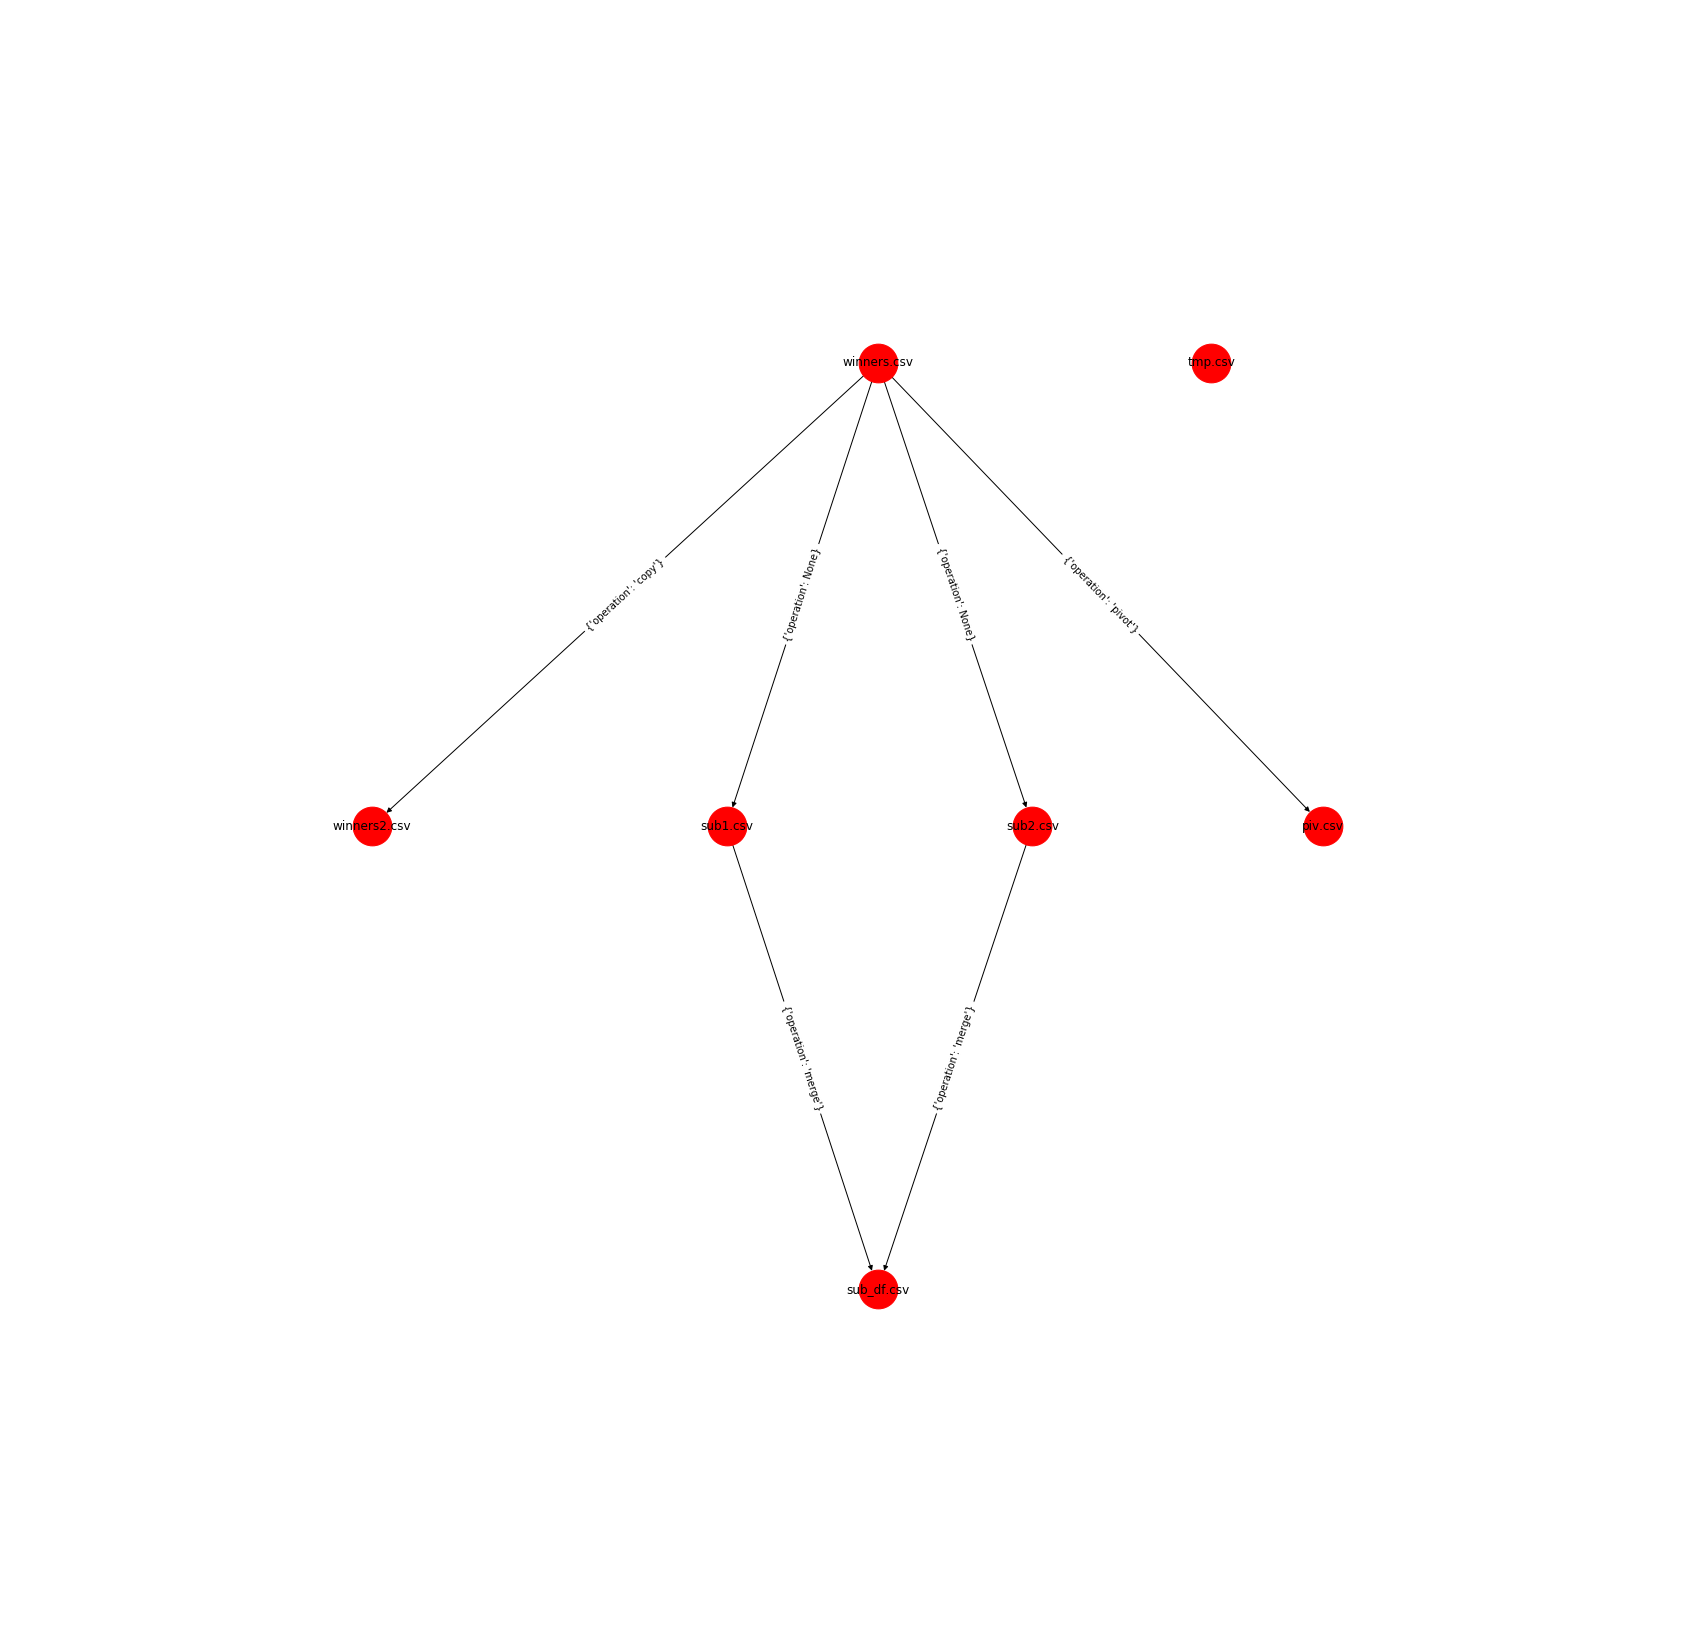

In [61]:
g = display_notebook('nb_986282.ipynb')

In [67]:
#dataframe_table('nb_986282.ipynb')
    
compare_file_pairs('nb_986282.ipynb', 'piv.csv', 'winners.csv')


,Australia,Bahrain,Malaysia,driverId
0,1.0,NaN,NaN,rosberg
1,2.0,NaN,NaN,kevin_magnussen
2,3.0,NaN,NaN,button
3,NaN,NaN,1.0,hamilton
4,NaN,NaN,2.0,rosberg


,carNum,pos,driverId,constructorId,grid,fastlaptime,fastlaprank,race
0,6,1,rosberg,mercedes,3,92.478,1,Australia
1,20,2,kevin_magnussen,mclaren,4,93.066,6,Australia
2,22,3,button,mclaren,10,92.917,5,Australia
3,44,1,hamilton,mercedes,1,103.066,1,Malaysia
4,6,2,rosberg,mercedes,3,103.960,2,Malaysia


0.09090909090909091

In [79]:
def pivot_detector(df1, df2):
    df1_cols = set(df1)
    df2_cols = set(df2)
    
    intersect = False
    
    for col in df1_cols:
        intersect = set(df1[col]).intersection(df2_cols)
        if intersect:
            return col, intersect
    
    
    for col in df2_cols:
        intersect = set(df2[col]).intersection(df1_cols)
        if intersect:
            return col, intersect
    
    
    return intersect
    

In [83]:
df1 = get_dataframe('nb_986282.ipynb', 'winners.csv')
df2 = get_dataframe('nb_986282.ipynb', 'piv.csv')

pivot_detector(df2,df1)

('race', {'Australia', 'Bahrain', 'Malaysia'})

In [81]:
test_nb = 'nb_986282.ipynb'

def get_all_pivots_wf(nb_name):
    artifact_dir = base_dir+nb_name+'/artifacts/'
    artifacts = [os.path.basename(p) for p in glob.glob(artifact_dir+'*.csv')]
    df_dict = {artifact: get_dataframe(nb_name, artifact) for artifact in artifacts}
    combinations = itertools.combinations(df_dict.keys(),2)
    for df1, df2 in combinations:
        result = pivot_detector(df_dict[df1], df_dict[df2])
        if result:
            print(df1, df2, result)
    return True
    

get_all_pivots_wf(test_nb)

winners2.csv piv.csv ('race', {'Australia', 'Bahrain', 'Malaysia'})
winners.csv piv.csv ('race', {'Australia', 'Bahrain', 'Malaysia'})
winners2014start.csv piv.csv ('race', {'Australia', 'Bahrain', 'Malaysia'})


True

## Join Detector

In [42]:
from itertools import combinations, chain

def generate_common_lattice(df1,df2):
    df1_cols = set(df1)
    df2_cols = set(df2)
    
    common_cols = df1_cols.intersection(df2_cols)
    #print(common_cols)
    
    lattice = [list(itertools.combinations(common_cols, i)) for i in range(1,len(common_cols)+1)]
            
    return lattice


def check_col_containment(df1, df2, colname, col2name=None):
    if(col2name==None):
        col2name = colname
    return set(df1[colname]).issubset(set(df2[col2name]))


def check_col_group_containment(df1, df2, colgroup, colgroup2=None):
    if(colgroup2==None):
        colgroup2 = colgroup
    
    df1valset = set(frozenset(u) for u in df1[list(colgroup)].values.tolist())
    df2valset = set(frozenset(u) for u in df2[list(colgroup2)].values.tolist())
    
    #print(df2valset)

    return df1valset.issubset(df2valset)

def remove_tup_lattice(lattice, badtup):
    # TODO: start comparing from len(badtup) level upwards
    for i in range(len(lattice)):
        level = lattice[i]
        new_level = [item for item in level if not set(badtup).issubset(set(item))]
        lattice[i] = new_level
    #print(lattice)
    return lattice

# Check for df1 >= df2 and max columns contained therein
def get_max_coherent_columns(df1,df2):
    lattice = generate_common_lattice(df1,df2)
    
    # All common columns are coherent at start
    coherent_cols = set(itertools.chain(*lattice[0])) 
    #return lattice

    for i in range(len(lattice)):
        level = lattice[i]
        new_lattice = lattice
        for tup in level:
            contained = check_col_group_containment(df1,df2,tup)
            if not contained:
                #print('removing', tup)
                new_lattice = remove_tup_lattice(new_lattice, tup)
        lattice = new_lattice
        
        #return lattice
    
    non_empty = [l for l in lattice if len(l)>0]
    if non_empty:
        return  non_empty[-1][0]
    return []
    

In [274]:
df1 = get_dataframe('nb_331056.ipynb', 'typeLoc.csv')
df2 = get_dataframe('nb_331056.ipynb', 'typeLoc__1.csv')
get_max_coherent_columns(df2,df1)

In [54]:
df1 = get_dataframe('nb_495072.ipynb', 'contribs.csv')
df2 = get_dataframe('nb_495072.ipynb', 'prop.csv')
j_result = get_dataframe('nb_495072.ipynb', 'merged.csv')
#get_max_coherent_columns(df2,df1)

In [58]:
set(df1).union(set(df2)) - set(j_result)

{'committee_name'}

In [71]:
common_cols = set(df1).intersection(set(j_result))
check_col_group_containment(j_result, df1, common_cols)

True

In [39]:
from tqdm import tqdm_notebook

def get_all_joins_wf(nb_name):
    joins = []
    artifact_dir = base_dir+nb_name+'/artifacts/'
    artifacts = [os.path.basename(p) for p in glob.glob(artifact_dir+'*.csv')]
    df_dict = {artifact: get_dataframe(nb_name, artifact) for artifact in artifacts}
    combos = itertools.combinations(df_dict.keys(),3)
    for combo in tqdm_notebook(combos):
        #print(combo)
        sizes = {x: len(set(df_dict[x])) for x in combo}
        if max(sizes.values())==min(sizes.values()):
            continue
        join_dest = list(sizes.keys())[list(sizes.values()).index(max(sizes.values()))] 
        join_sources = tuple(x for x in combo if x is not join_dest)
        
        if set(df_dict[join_sources[0]]).union(set(df_dict[join_sources[1]])) == set(df_dict[join_dest]):
            # print ('Column Union Match:', join_dest, join_sources)
            
            coherent_1 = get_max_coherent_columns(df_dict[join_sources[0]], df_dict[join_dest])
            coherent_2 = get_max_coherent_columns(df_dict[join_sources[1]], df_dict[join_dest])
            
            # Check if the coherent columns generate the output set
            if set(coherent_1).union(set(coherent_2)) == set(df_dict[join_dest]):
                print('coherent:', (join_dest, join_sources))
                if set(coherent_1).intersection(set(coherent_2)): # Check if the intersection is not null
                    print('intersection: ', (join_dest, join_sources))
                    joins.append((join_dest, join_sources))
        
    return joins
        



In [43]:
test_nb = 'nb_986282.ipynb'

get_all_joins_wf(test_nb)

coherent: ('winners2.csv', ('sub2.csv', 'winners.csv'))
intersection:  ('winners2.csv', ('sub2.csv', 'winners.csv'))
coherent: ('sub_df.csv', ('sub2.csv', 'sub1.csv'))
intersection:  ('sub_df.csv', ('sub2.csv', 'sub1.csv'))
coherent: ('winners2.csv', ('sub1.csv', 'winners.csv'))
intersection:  ('winners2.csv', ('sub1.csv', 'winners.csv'))
coherent: ('winners2.csv', ('sub_df.csv', 'winners.csv'))
intersection:  ('winners2.csv', ('sub_df.csv', 'winners.csv'))
coherent: ('winners2.csv', ('winners.csv', 'winners2014start.csv'))
intersection:  ('winners2.csv', ('winners.csv', 'winners2014start.csv'))



[('winners2.csv', ('sub2.csv', 'winners.csv')),
 ('sub_df.csv', ('sub2.csv', 'sub1.csv')),
 ('winners2.csv', ('sub1.csv', 'winners.csv')),
 ('winners2.csv', ('sub_df.csv', 'winners.csv')),
 ('winners2.csv', ('winners.csv', 'winners2014start.csv'))]

# DEBUG 

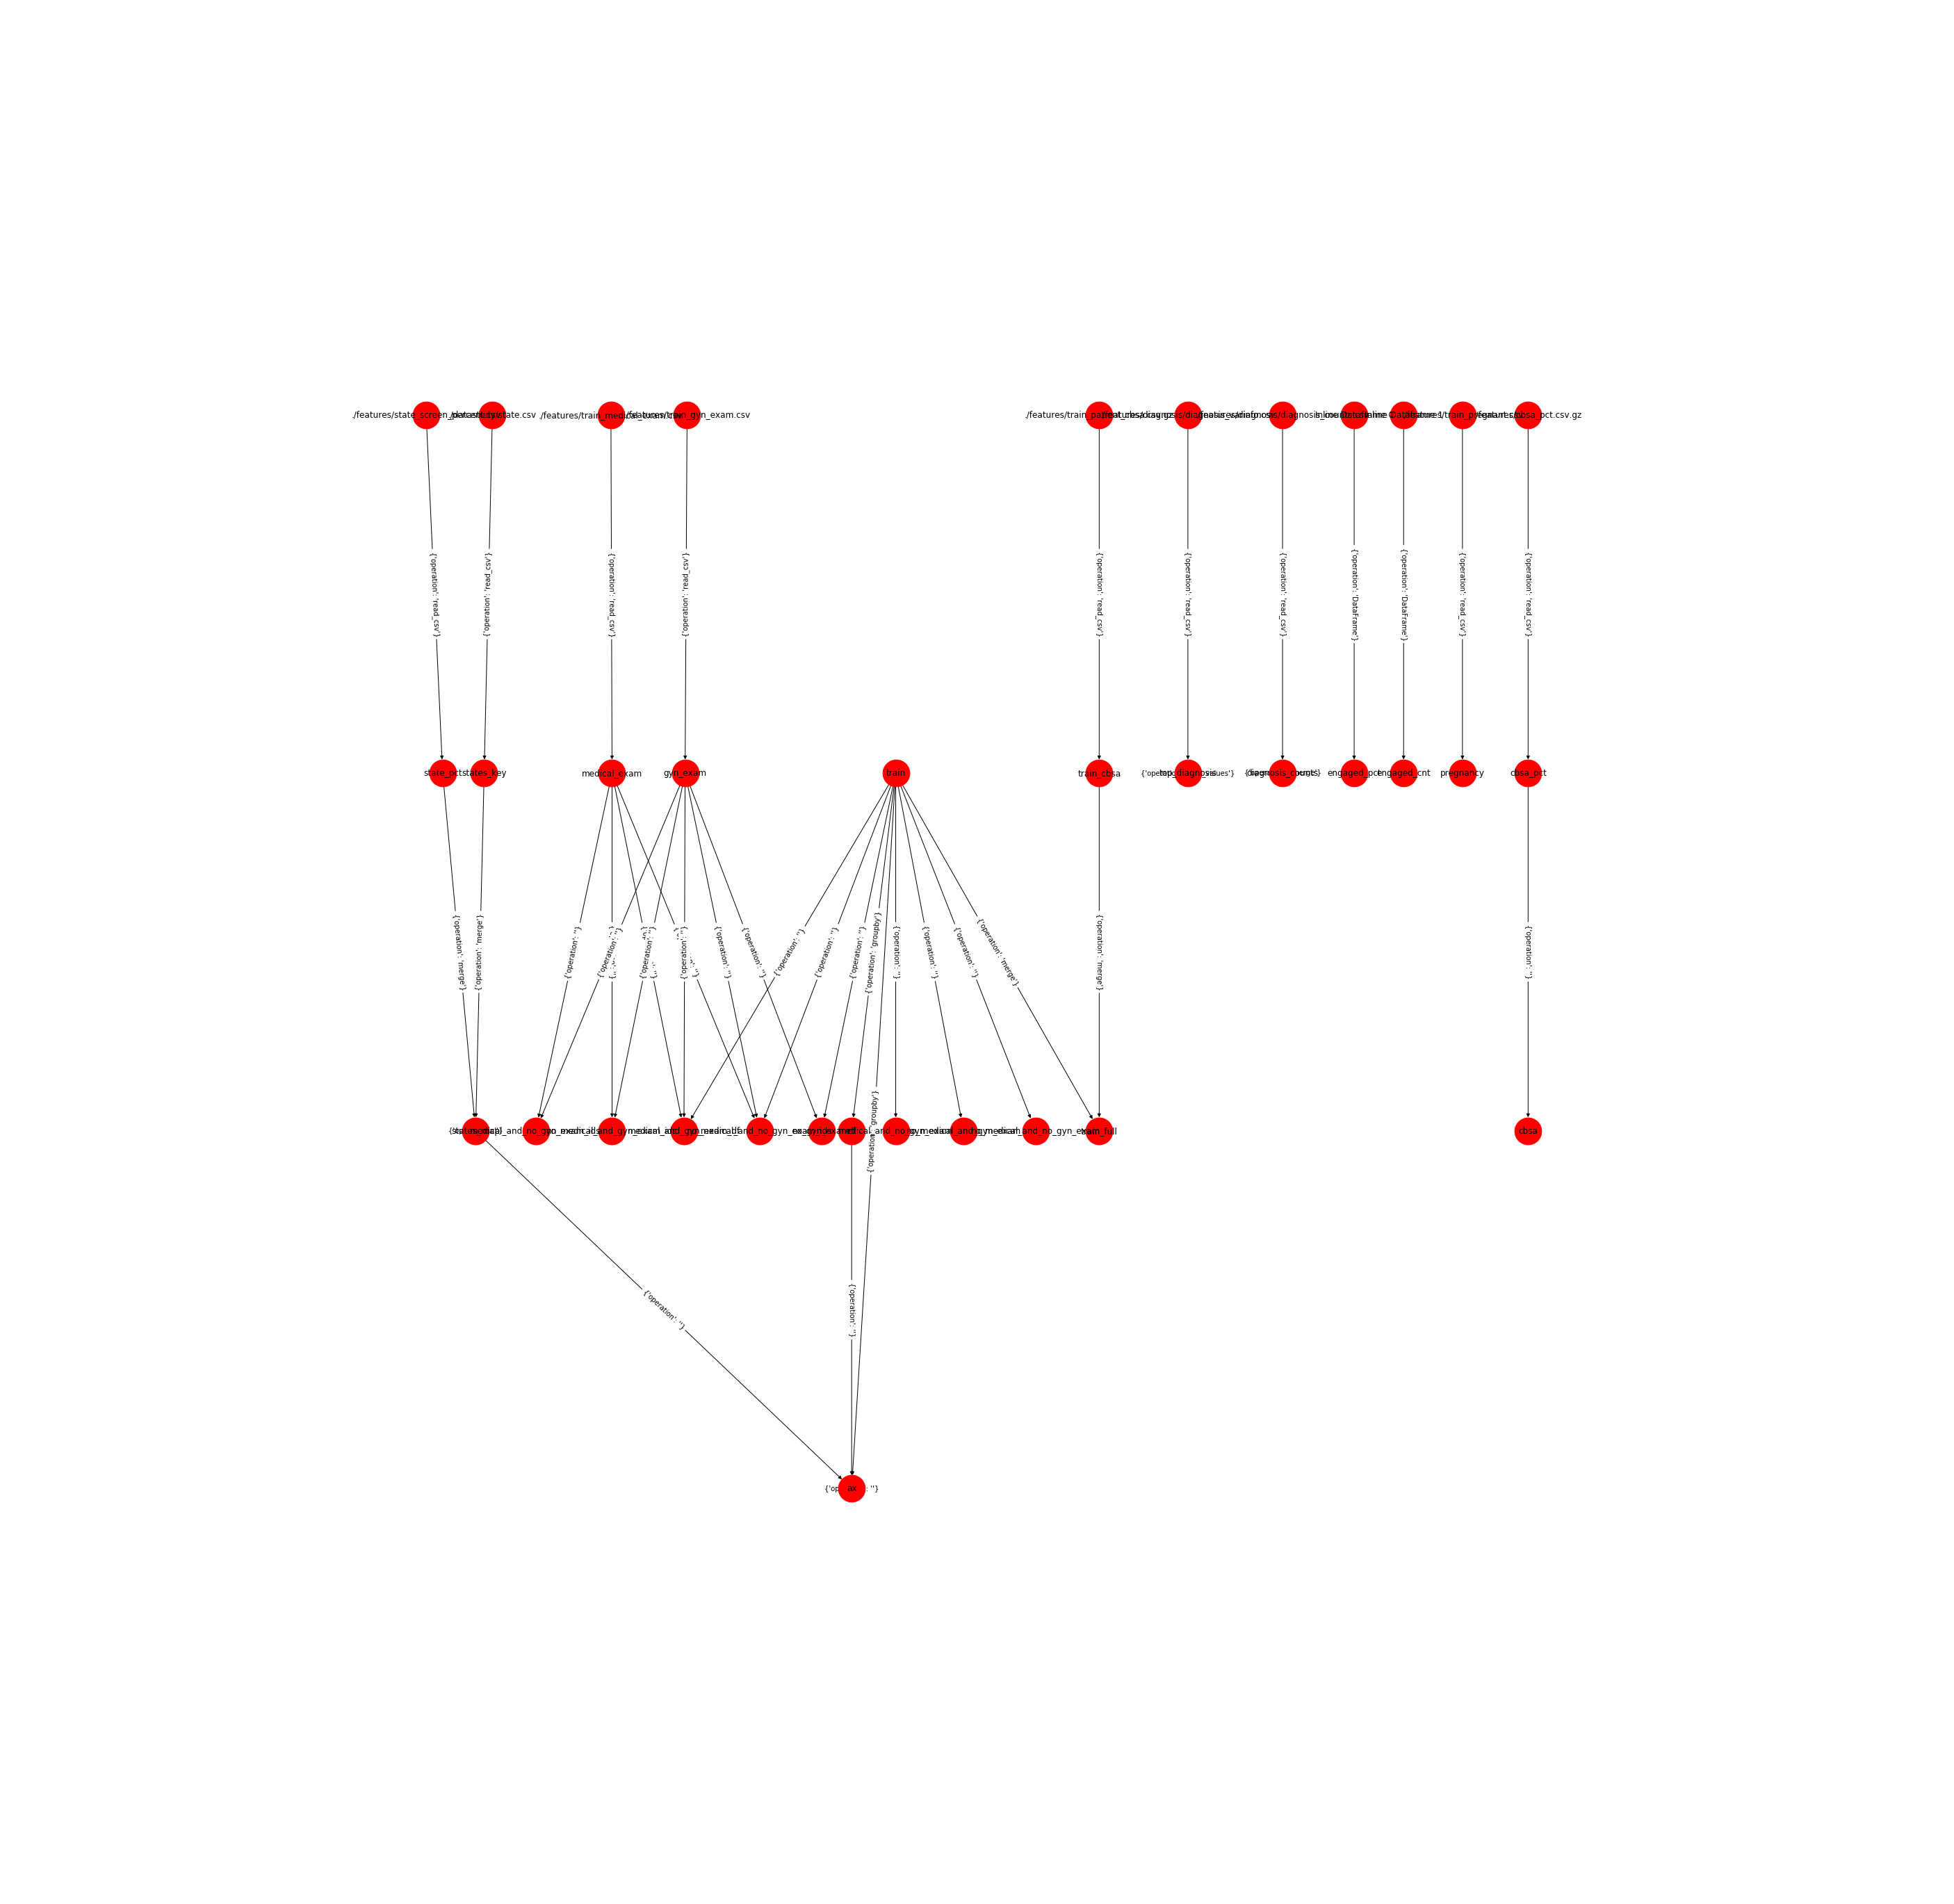

In [193]:
G = nx.read_gpickle('/media/suhail/Data/experiments/lin_sample/'+'nb_306062.ipynb.gpickle')
graphs.draw_graph(G, canvas_size=(50,50))